# Introduction

Here I compare IFN-β and IFN-ɣ in classical monocytes across many different metrics including differential expression, GO enrichment network analysis, and transcription factor utilization.

# Setup

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy
from sklearn.metrics import jaccard_score
import requests
import pprint
import json

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import networkx as nx
from textwrap import wrap

from nero import utils as nrutils
from nero import Augustus as aug
from nero import Nero as nr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

In [4]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['ct_colors']['ct2']['hex']
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

## Functions

In [5]:
def subsetdict(df, sdict):
    return df.loc[pd.concat([df[i].isin([j]) if type(j) == str else df[i].isin(j) for i, j in sdict.items()], axis=1).all(1), :]

# Load in Data

In [6]:
de = dict()

In [7]:
de['mrna'] = pd.read_pickle(prefix_mrna + 'pkls/de.pkl')
de['adts'] = pd.read_pickle(prefix_adts + 'pkls/de.pkl')

In [8]:
de['mrna']

baseMean      l2fc     lfcSE      stat    pvalue      padj  \
AL669831.5    1.818579  0.069607  0.191369  0.363731  0.716059  0.999359   
LINC00115     1.352093  0.022045  0.222006  0.099297  0.920902  0.999359   
FAM41C        1.440097 -0.198115  0.215369 -0.919884  0.357633  0.999359   
NOC2L        11.879640 -0.075162  0.169489 -0.443461  0.657432  0.999359   
PLEKHN1       1.346427  0.255864  0.223025  1.147245  0.251280  0.989405   
...                ...       ...       ...       ...       ...       ...   
MT-ND5      113.655291 -0.919171  0.204464 -4.495510  0.000007  0.000040   
MT-ND6       13.255092 -0.693410  0.192642 -3.599468  0.000319  0.000938   
MT-CYB      546.037387 -0.953236  0.226756 -4.203797  0.000026  0.000117   
AC004556.1    1.379325 -0.128034  0.220508 -0.580632  0.561489  0.596582   
AC240274.1    1.497136 -0.359927  0.214244 -1.679982  0.092961  0.122386   

            abs(l2fc)  padj0   -log10p   mod anlys cttype cond     ct  
AL669831.5   0.069607  False  0.000278  mrna  IFNs    ct2  B-G  B_Mem  
LINC00115    0.022045  False  0.000278  mrna  IFNs    ct2  B-G  B_Mem  
FAM41C       0.198115  False  0.000278  mrna  IFNs    ct2  B-G  B_Mem  
NOC2L        0.075162  False  0.000278  mrna  IFNs    ct2  B-G  B_Mem  
PLEKHN1      0.255864  False  0.004626  mrna  IFNs    ct2  B-G  B_Mem  
...               ...    ...       ...   ...   ...    ...  ...    ...  
MT-ND5       0.919171  False  4.398126  mrna   all    ct3    R  T4_CM  
MT-ND6       0.693410  False  3.027866  mrna   all    ct3    R  T4_CM  
MT-CYB       0.953236  False  3.932113  mrna   all    ct3    R  T4_CM  
AC004556.1   0.128034  False  0.224330  mrna   all    ct3    R  T4_CM  
AC240274.1   0.359927  False  0.912269  mrna   all    ct3    R  T4_CM  

[2288401 rows x 14 columns]

# Make Compare Object

In [9]:
class DECompare:
    '''
    DE comparison object to allow for quick comparisons of DE results between two samples.
    `de`: de object as created by create_pkls.ipynb
    `comp`: 2-tuple of two 2-tuples ((cond0, ct0), (cond1, ct1))
    `de_keys`: additional keys to subset the pd.DataFrame using subsetdict()
    '''
    
    def __init__(self, de, comp, de_keys=None, cond_labels=True):
        
        
        if not isinstance(de_keys, type(None)):
            de = subsetdict(de, de_keys)

        (cond0, ct0), (cond1, ct1) = comp
        de_keys = {'cond': cond0, 'ct': ct0}
        de_cond0 = subsetdict(de, de_keys)
        
        de_keys = {'cond': cond1, 'ct': ct1}
        de_cond1 = subsetdict(de, de_keys)

        if cond_labels:
            assert len(cond0) == 1 and len(cond1) == 1, "Conditions should each be str of len == 1"
            labels = (cond0, cond1)
        else:
            labels = ('0', '1')


        de_cond0.columns = de_cond0.columns + '-' + labels[0]
        de_cond1.columns = de_cond1.columns + '-' + labels[1]

        comp_df = pd.concat([de_cond0, de_cond1], axis=1)

        comp_df =  comp_df[[''.join(i) for i in it.product(['l2fc', 'padj'], ('-' + labels[0], '-' + labels[1]))]].copy()
        l0s, l1s, p0s, p1s =  [''.join(i) for i in it.product(['l', 'p'], labels)]
        comp_df.columns = [l0s, l1s, p0s, p1s]
        comp_df =  comp_df[[l0s, p0s, l1s, p1s]].copy()

        comp_df[l0s] = comp_df[l0s].fillna(0)
        comp_df[p0s] = comp_df[p0s].fillna(1)
        comp_df[l1s] = comp_df[l1s].fillna(0)
        comp_df[p1s] = comp_df[p1s].fillna(1)

        self.df = comp_df
        self.labels = labels
        self.comp = comp
        self.de_keys = de_keys
        self.cols = (l0s, l1s, p0s, p1s) # store here just in case user adjusts DECompare.df
        return
    
    def __repr__(self):
        printable = 'DECompare of %s with %d DE features.' % (str(self.comp), self.df.shape[0])
        return printable
    
    def create_bool_dict(self, pthresh_keep=0.05, pthresh_ns=0.05, lthresh=0.5):
        '''
        
        '''
        
        combos = [''.join(np.ravel(i)) for i in list(it.product(it.product([self.labels[0]], ['d', 'n', 'u']), it.product([self.labels[1]], ['d', 'n', 'u'])))]
        
        comp_df = self.df
        bool_dict = dict()
        
        (l0s, l1s, p0s, p1s) = self.cols
        
        for combo in combos:
            # adds in this order ['0d1d', '0d1n', '0d1u', '0n1d', '0n1n', '0n1u', '0u1d', '0u1n', '0u1u']
            if combo[1] == 'u':
                bool0 = (comp_df[l0s].values > lthresh) & (comp_df[p0s].values <= pthresh_keep)
            elif combo[1] == 'd':
                bool0 = (comp_df[l0s].values < -lthresh) & (comp_df[p0s].values <= pthresh_keep)
            elif combo[1] == 'n':
                bool0 = (comp_df[p0s].values > pthresh_ns)
            else:
                raise ValueError
            if combo[3] == 'u':
                bool1 = (comp_df[l1s].values > lthresh) & (comp_df[p1s].values <= pthresh_keep)
            elif combo[3] == 'd':
                bool1 = (comp_df[l1s].values < -lthresh) & (comp_df[p1s].values <= pthresh_keep)
            elif combo[3] == 'n':
                bool1 = (comp_df[p1s].values > pthresh_ns)
            else:
                raise ValueError
            bool_dict[combo] = bool0 & bool1
        
        self.bool = bool_dict
        return
    
    def sub(self, bool_keys):
        if isinstance(bool_keys, str):
            bool_keys = [bool_keys]
        return self.df.loc[np.stack([self.bool[i] for i in bool_keys]).any(0)]
    
    def add_colors(self, colors=None):
        
        self.check_attr('bool')
        dxs = list(self.bool.keys())
        
        if isinstance(colors, type(None)):
            # should be in this order ['0d1d', '0d1n', '0d1u', '0n1d', '0n1n', '0n1u', '0u1d', '0u1n', '0u1u']
            colors = dict(zip(dxs,
                              [
                                  'blue',
                                  mpl.colors.rgb2hex(nrutils.adj_light('orange', 1.2)),
                                  mpl.colors.rgb2hex(nrutils.adj_light('green', 0.7)),
                                  mpl.colors.rgb2hex(nrutils.adj_light('green', 1.2)),
                                  'lightgray',
                                  'green',
                                  mpl.colors.rgb2hex(nrutils.adj_light('orange', 0.7)),
                                  'orange',
                                  'red'
                             
                         ]
                        )
                    )
        else:
            assert isinstance(colors, dict)
            if len(colors) != 9: # colors should be {cond0: color, cond2: color}
                try:
                    color0 = colors[self.labels[0]]
                    color1 = colors[self.labels[1]]
                except KeyError:
                    try:
                        color0 = colors[self.comp[0][0]]
                        color1 = colors[self.comp[1][0]]
                    except KeyError: 
                        raise ValueError("Provided keyword `colors` not understood")
                colors = dict(zip(dxs, # they should have been added in correct order
                                  [
                                      'blue',
                                      mpl.colors.rgb2hex(nrutils.adj_light(color0, 1.2)),
                                      mpl.colors.rgb2hex(nrutils.adj_light(color1, 0.7)),
                                      mpl.colors.rgb2hex(nrutils.adj_light(color1, 1.2)),
                                      'lightgray',
                                      color1,
                                      mpl.colors.rgb2hex(nrutils.adj_light(color0, 0.7)),
                                      color0,
                                      'red'
                                  ]
                                 )
                             )
            else: # it should be a colordict of length 9 with dxs, just pass
                pass
        
        self.dx_colors = colors
        return
    
    def check_attr(self, attr, **kwargs):
        if attr == 'bool':
            try:
                self.bool
            except AttributeError:
                print("Running DECompare.create_bool_dict().")
                self.create_bool_dict()
                
        elif attr == 'dx_colors':
            colors = kwargs['colors']
            if isinstance(colors, type(None)):
                try:
                    colors = self.dx_colors
                except AttributeError:
                    self.add_colors(colors)
            else:
                self.add_colors(colors)
        else:
            raise ValueError('Provided `attr` not understood.')
        return
    
    def plot_scatter(self, colors=None, figsize=(5, 5), s=5, alpha=0.5):
        
        self.check_attr('bool')
        dxs = list(self.bool.keys())
        self.check_attr('dx_colors', colors=colors)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        comp_df = self.df
        (l0s, l1s, p0s, p1s) = self.cols
        
        
        for dx in [dxs[4]] + dxs[:4] + dxs[5:]: # plot the non-sigs first
            ax.scatter(*comp_df.loc[self.bool[dx], [l0s, l1s]].T.values, c=self.dx_colors[dx], s=s, alpha=alpha)
        

        lim = (comp_df[[l0s, l1s]].min().min(), comp_df[[l0s, l1s]].max().max())
        ax.set_axisbelow(True)
        ax.grid(color='lightgray')
        ax.plot(lim, lim, color='gray', linewidth=1, linestyle='--', zorder=3)
        
#         ax = idax(ax, lim=lim)
        return ax

    def make_bubble_arr(self, features, focus_dx=None, normed=False, sig_params=None, colors=None):
        
        self.check_attr('bool')
        dxs = list(self.bool.keys())
        self.check_attr('dx_colors', colors=colors)
        
        if isinstance(focus_dx, type(None)):
            # ['0d1d', '0d1n', '0d1u', '0n1d', '0n1n', '0n1u', '0u1d', '0u1n', '0u1u']
            focus_dx = dxs[:4] + dxs[5:]
        
        df_plot = pd.concat([self.df[self.bool[dx]] for dx in self.bool], keys=self.bool, names=['dx', 'gene']).reset_index('dx')
        plot_bool = df_plot.index.isin(features), 
        
        df_plot = df_plot.loc[plot_bool]
        df_plot = df_plot[~df_plot.duplicated()]
        df_plot = df_plot.sort_values(by='dx')
        
        feature_order = list()
        color_list = list()
        len_dict = dict()
        
        (l0, l1, p0, p1) = self.cols
        
        for dx in focus_dx:
            df_clust = df_plot[df_plot['dx'] == dx][[l0, l1]]
            if df_clust.shape[0] > 1:
                Z = scipy.cluster.hierarchy.linkage(df_clust, method='average', optimal_ordering=True)
                order = aug.get_ordering(Z, df_clust.index)
                maxes = df_clust.loc[order].max(1)
                if maxes[0] < maxes[-1]:
                    order = order[::-1]
                feature_order.append(order)
                len_dict[dx] = len(order)
                color_list.append([self.dx_colors[dx]]*order.shape[0])
            elif df_clust.shape[0] == 1:
                feature_order.append([df_clust.index[0]])
                len_dict[dx] = 1
                color_list.append([self.dx_colors[dx]])
            elif df_clust.shape[0] == 0:
                continue
            else:
                raise ValueError('Incorrect shape for df_clust.')
                
        feature_order = [i for j in feature_order for i in j]
        df_plot_ordered = df_plot.loc[feature_order]
        
        if normed:
            sig_vals = nrutils.norm_between(-np.log10(np.concatenate([df_plot_ordered[p0].values, df_plot_ordered[p1].values])), 1, 10)
        else:
            assert type(sig_params) != type(None)
            bins = sig_params['bins']
            min_size, max_size = sig_params['dot_size_range']
            sig_vals = np.digitize(np.concatenate([df_plot_ordered[p0].values, 
                                                   df_plot_ordered[p1].values]), bins)*((max_size - min_size)/len(bins)) + min_size

        bubble_plot_arr = np.stack([
            [1]*df_plot_ordered.shape[0] + [0]*df_plot_ordered.shape[0], # 1 then 0 so condition0 is top row of bubble plot
            np.concatenate([np.arange(len(feature_order))]*2),
            np.concatenate([df_plot_ordered[l0].values, df_plot_ordered[l1].values]),
            sig_vals
        ], axis=1)
        
        
        self.bubble = {
            'features': features,
            'dxs': focus_dx,
            'arr': bubble_plot_arr,
            'lens': len_dict,
            'order': feature_order
        }
        print('Bubble plot params added to DECompare.bubble')
        
        return
        

    def plot_bubble(self, features, focus_dx=None, protein=False, vlim=None, normed=False, sig_params=None, colors=None, plot_params=None):
            
        self.check_attr('bool')
        dxs = list(self.bool.keys())
        self.check_attr('dx_colors', colors=colors)
        
        if isinstance(focus_dx, type(None)):
            # ['0d1d', '0d1n', '0d1u', '0n1d', '0n1n', '0n1u', '0u1d', '0u1n', '0u1u']
            focus_dx = dxs[:4] + dxs[5:]
            
        if isinstance(vlim, type(None)):
            if protein:
                vlim = (-0.5, 0.5)
            else:
                vlim = (-2, 2)
        
        if type(plot_params) == type(None):
            plot_params = {
                'height': 1.25,
                'ylim_buffer': 0.5,
                'height_ratios': [3, .5],
                'linewidth': 5
            }
            
        self.make_bubble_arr(features, focus_dx=focus_dx, normed=normed, sig_params=sig_params, colors=colors)
        
        bubble_plot_arr = self.bubble['arr']
        len_dict = self.bubble['lens']
        feature_order = self.bubble['order']
        

        font_color = 'gray' if protein else 'black'

        fig, ax = plt.subplots(2, 1, figsize=(len(feature_order)/2, plot_params['height']), gridspec_kw={'height_ratios': plot_params['height_ratios'], 'hspace': 0})
        ax[0].scatter(bubble_plot_arr[:, 1], bubble_plot_arr[:, 0], 
                      s=bubble_plot_arr[:, 3]*20, c=bubble_plot_arr[:, 2],
                      cmap='bwr', vmin=vlim[0], vmax=vlim[1],
        #            edgecolor='k', linewidth=0.5
                  )

        for axes in ax:
            axes.set_facecolor((1, 1, 1, 0))
            axes.set_xlim(-1, len(feature_order))
        ax[0].set_ylim(0 - plot_params['ylim_buffer'], 1 + plot_params['ylim_buffer'])
        ax[0].set_yticks([0, 1])
        ax[0].set_yticklabels(['IFN-ɣ', 'IFN-β'])

        ax[0].xaxis.set_label_position('top') 
        ax[0].xaxis.tick_top()
        ax[0].set_xticks(np.arange(len(feature_order)))
        # [i.set_visible(False) for i in ax[0].xax[0]is.get_ticklines()]
        
        if protein:
            ax[0].set_xticklabels([i.split('|')[1] for i in feature_order], rotation=45, ha='left', fontdict={'weight':'bold', 'size':11, 'color':font_color});
        else:
            ax[0].set_xticklabels(feature_order, rotation=45, ha='left', fontdict={'weight':'bold', 'size':11, 'color':font_color});

        for spine in ['right', 'bottom']:
            ax[0].spines[spine].set_visible(False)
        for spine in ['right', 'left', 'bottom', 'top']:
            ax[1].spines[spine].set_visible(False)

        ax[1].set_xticks(np.arange(len(feature_order)))
        ax[1].set_xlim(ax[0].get_xlim())
        # ax[1].set_ylim(0, 0.5)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        
        ax[0].grid()
        
        lastpos=0
        for dx in len_dict:
            ax[1].plot([
                lastpos - 0.5, lastpos + len_dict[dx] - 0.5], 
                [0.5, 0.5], 
                c=self.dx_colors[dx], linewidth=plot_params['linewidth'], solid_capstyle='butt'
            )
            lastpos += len_dict[dx]
        
        return ax[0], ax[1]

In [10]:
comp = ('B', 'cM'), ('G', 'cM')

In [11]:
de_keys = {'anlys': 'all', 'cttype': 'ct2'}
decomp_mrna = DECompare(de['mrna'], comp, de_keys)
decomp_adts = DECompare(de['adts'], comp, de_keys)

In [12]:
decomp_mrna.create_bool_dict()
decomp_adts.create_bool_dict(lthresh=0)

# Plot Log2FoldChanges

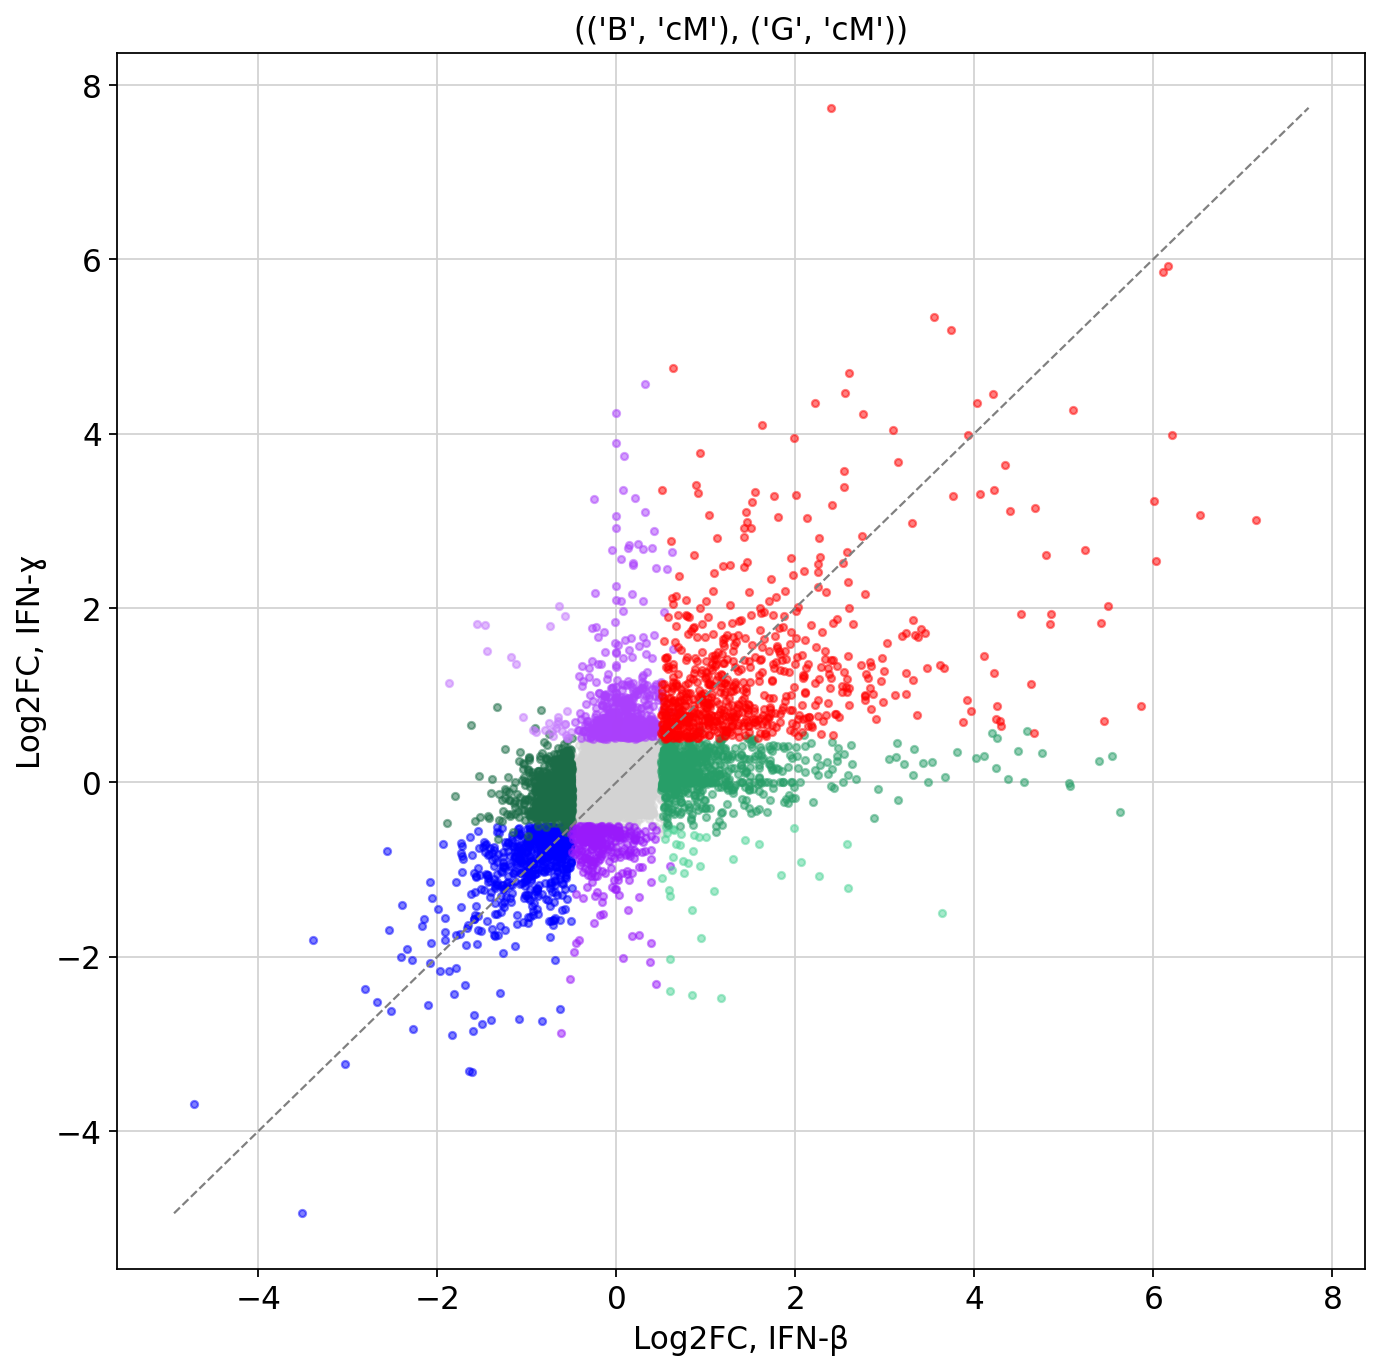

In [13]:
ax = decomp_mrna.plot_scatter(colors=cond_colors, figsize=(10, 10), s=10)
ax.set_xlabel('Log2FC, IFN-β')
ax.set_ylabel('Log2FC, IFN-ɣ');
ax.set_title(comp);

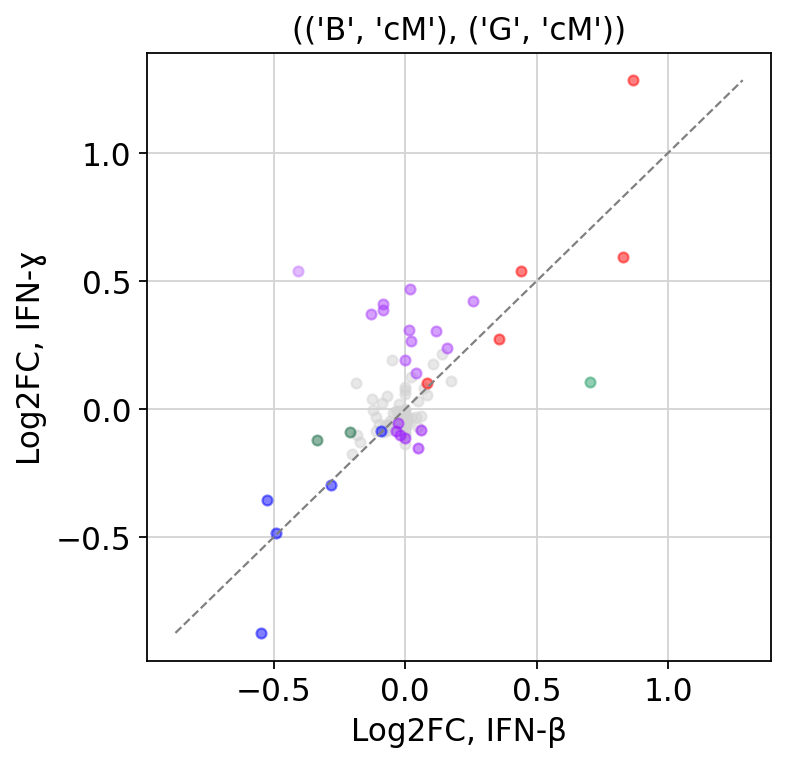

In [14]:
ax = decomp_adts.plot_scatter(colors=cond_colors, figsize=(5, 5), s=20)
ax.set_xlabel('Log2FC, IFN-β')
ax.set_ylabel('Log2FC, IFN-ɣ');
ax.set_title(comp);

# BubblePlots of Individual Genes and Proteins

## Define Feature Sets

In [15]:
feature_sets = dict()

In [16]:
feature_sets['chemokines'] = ['CCL1', 'CCL2', 'CCL3', 'CCL3L1', 'CCL3L3', 'CCL4', 'CCL4L1', 'CCL4L2', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13', 'CCL14', 'CCL15', 'CCL16', 'CCL17', 'CCL18', 'CCL19', 'CCL20', 'CCL21', 'CCL22', 'CCL23', 'CCL24', 'CCL25', 'CCL26', 'CCL27', 'CCL28', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL8', 'CXCL9', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CXCL14', 'CXCL16', 'CXCL17', 'CX3CL1', 'XCL1', 'XCL2']
feature_sets['chemokine_receptors'] = ['XCR1', 'CXCR1', 'CXCR2', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'CX3CR1', 'ACKR1', 'ACKR2', 'ACKR3', 'ACKR4', 'CCRL2', 'PITPNM3', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CCR10']
feature_sets['ILs'] = ['IL1A', 'IL1B', 'IL1F10', 'IL1RN', 'IL2', 'IL3', 'IL4', 'IL5', 'IL6', 'IL7', 'CXCL8', 'IL9', 'IL10', 'IL11', 'IL12A', 'IL12B', 'IL13', 'IL15', 'IL16', 'IL17A', 'IL17B', 'IL17C', 'IL17D', 'IL17F', 'IL18', 'IL19', 'IL20', 'IL21', 'IL22', 'IL23A', 'IL24', 'IL25', 'IL26', 'IL27', 'IL31', 'IL32', 'IL33', 'IL34', 'IL36A', 'IL36B', 'IL36G', 'IL36RN', 'IL37']
feature_sets['IL_receptors'] = ['CXCR1', 'CXCR2', 'IL1RAP', 'IL1RAPL1', 'IL1RAPL2', 'IL1RL1', 'IL1RL2', 'IL1R1', 'IL1R2', 'IL2RA', 'IL2RB', 'IL2RG', 'IL3RA', 'IL4R', 'IL5RA', 'IL6R', 'IL6ST', 'IL7R', 'IL9R', 'IL10RA', 'IL10RB', 'IL11RA', 'IL12RB1', 'IL12RB2', 'IL13RA1', 'IL13RA2', 'IL15RA', 'IL17RA', 'IL17RB', 'IL17RC', 'IL17RD', 'IL17RE', 'IL18RAP', 'IL18R1', 'IL20RA', 'IL20RB', 'IL21R', 'IL22RA1', 'IL22RA2', 'IL27RA', 'IL31RA']
feature_sets['MHC'] = ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPA2', 'HLA-DPA3', 'HLA-DPB1', 'HLA-DPB2', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DQB3', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB2', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-DRB6', 'HLA-DRB7', 'HLA-DRB8', 'HLA-DRB9', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'HLA-J', 'HLA-K', 'HLA-L', 'HLA-N', 'HLA-P', 'HLA-S', 'HLA-T', 'HLA-U', 'HLA-V', 'HLA-W', 'HLA-X', 'HLA-Y', 'HLA-Z']
feature_sets['MiHC'] = ['AKAP13', 'APOBEC3B', 'ARHGDIB', 'BCAT2', 'BCL2A1', 'CD19', 'CENPM', 'CTSH', 'C19orf48', 'DDX3Y', 'DPH1', 'EBI3', 'ERAP1', 'ERBB2', 'GEMIN4', 'HEATR1', 'ARHGAP45', 'HMHB1', 'HMSD', 'KDM5D', 'PUM3', 'RESF1', 'LY75', 'MR1', 'MTHFD1', 'MYO1G', 'NUP133', 'PDCD11', 'PI4K2B', 'PKN3', 'PRCP', 'PTK2B', 'P2RX5', 'RPS4Y1', 'SLC1A5', 'SLC19A1', 'SON', 'SP110', 'SSR1', 'SWAP70', 'TMSB4Y', 'TOR3A', 'TRIM22', 'TRIM42', 'TRIP10', 'TYMP', 'UGT2B17', 'USP9Y', 'UTY', 'WNK1', 'ZNF419']

In [17]:
focus_dx = ['BdGd', 'BdGn', 'BdGu', 'BnGd', 'BnGu', 'BuGd', 'BuGn', 'BuGu']

In [18]:
sig_params = {
    'bins': [5e-2, 1e-2, 1e-5, 1e-10, 1e-30, 1e-50],
    'dot_size_range': (0.3, 15)
}

In [19]:
def get_features(feature_list, protein=False):
    if protein:
        return decomp_adts.df.index[np.stack([decomp_adts.df.index.str.contains(i) for i in feature_list]).any(0)].values
    else:
        return np.intersect1d(feature_list, decomp_mrna.df.index.values)

## Plot

################ chemokines ################
Bubble plot params added to DECompare.bubble


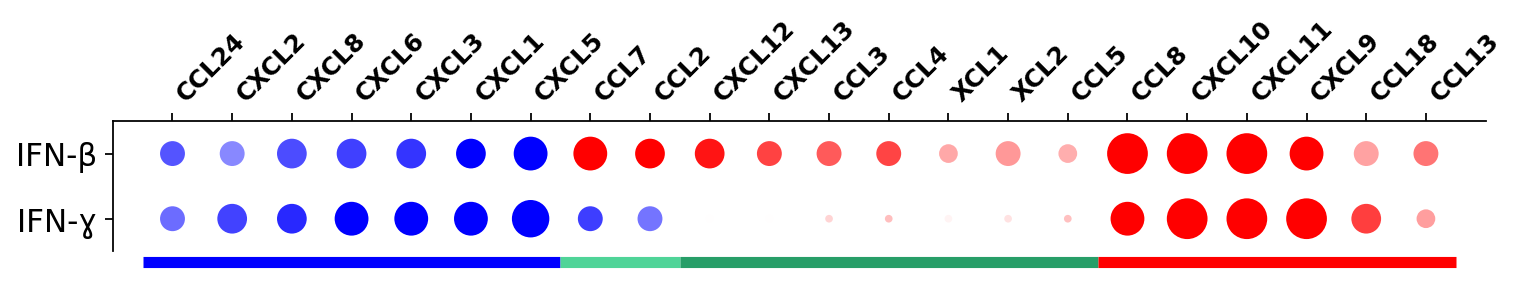

No DE proteins for this feature set.


################ chemokine_receptors ################
Bubble plot params added to DECompare.bubble


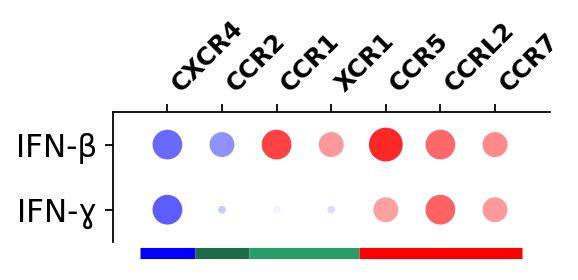

Bubble plot params added to DECompare.bubble


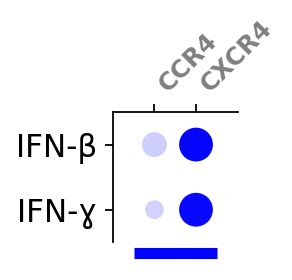



################ ILs ################
Bubble plot params added to DECompare.bubble


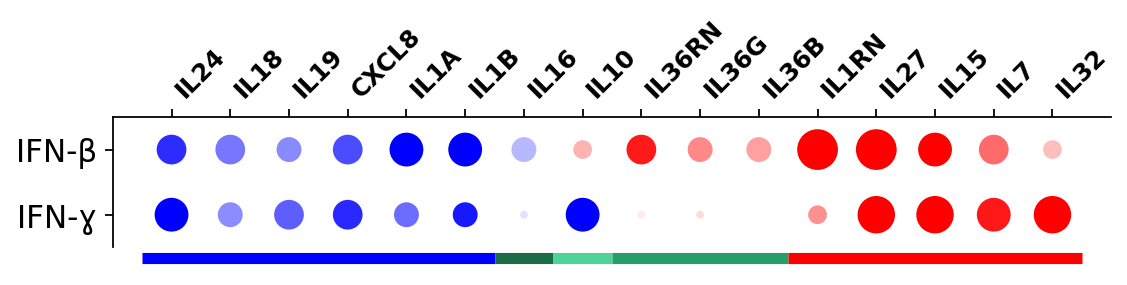

Bubble plot params added to DECompare.bubble


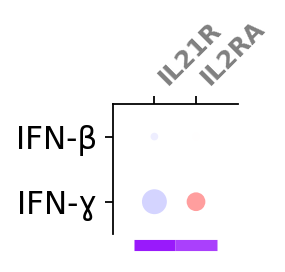



################ IL_receptors ################
Bubble plot params added to DECompare.bubble


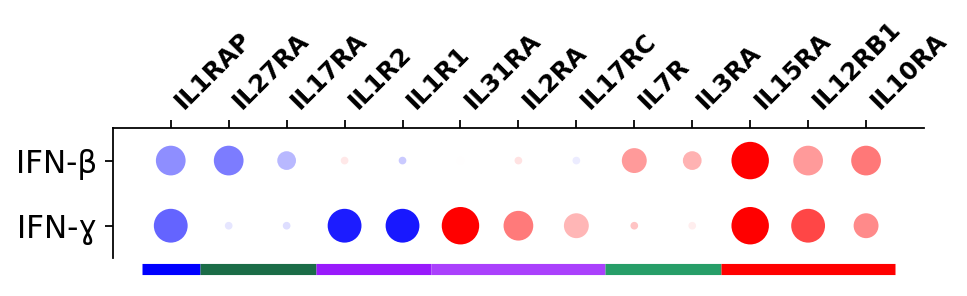

Bubble plot params added to DECompare.bubble


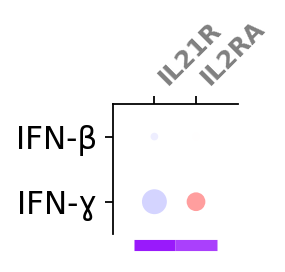



################ MHC ################
Bubble plot params added to DECompare.bubble


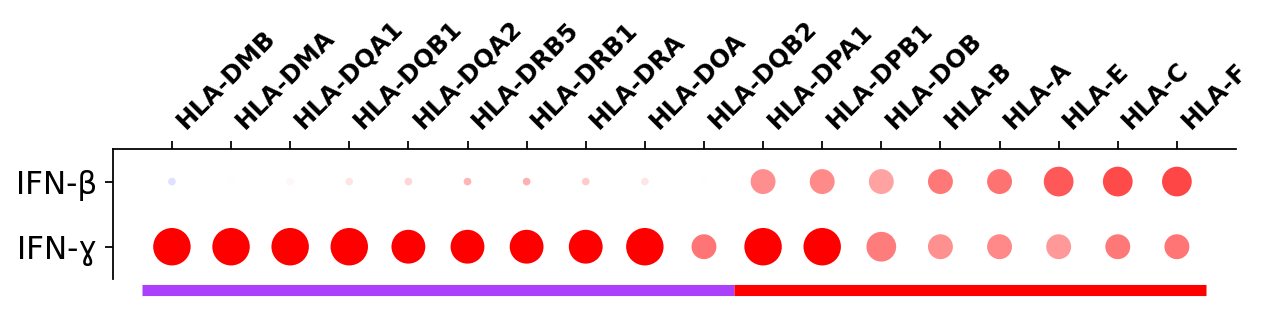

No DE proteins for this feature set.


################ MiHC ################
Bubble plot params added to DECompare.bubble


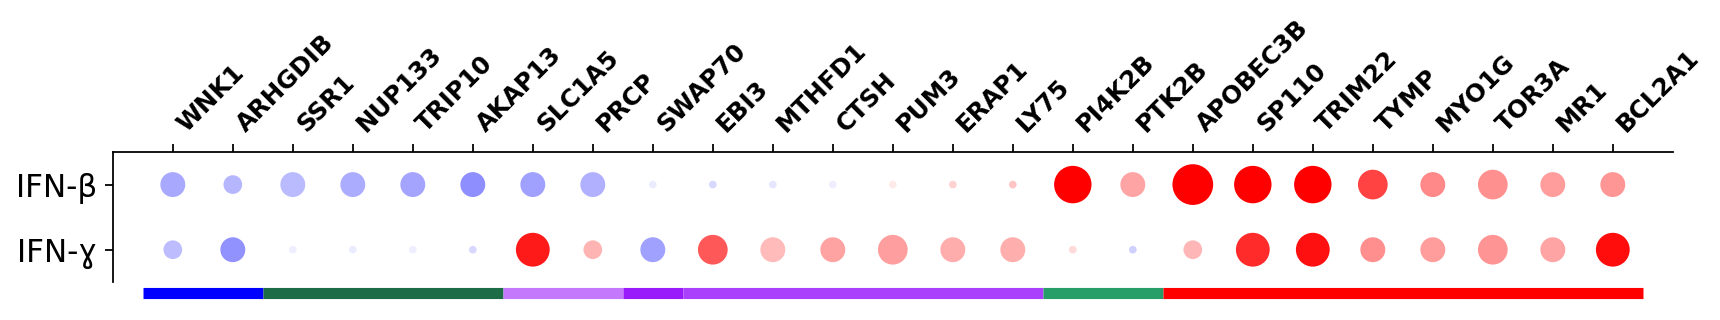

Bubble plot params added to DECompare.bubble


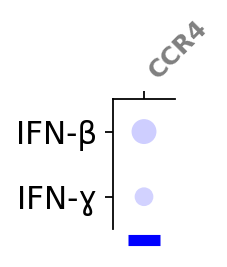

In [20]:
for fset_name in feature_sets:
    print('################ ' + fset_name + ' ################')
    txs = get_features(feature_sets[fset_name], protein=False)
    prots = get_features(feature_sets[fset_name], protein=True)
    if len(txs) > 1:
        decomp_mrna.plot_bubble(txs, focus_dx=focus_dx, sig_params=sig_params, protein=False)
        plt.show()
    else:
        print('No DE transcripts for this feature set.')
    if len(prots) > 1:
        decomp_adts.plot_bubble(prots, focus_dx=focus_dx, sig_params=sig_params, protein=True)
        plt.show()
    else:
        print('No DE proteins for this feature set.')
    print('')
    print('')

# BiNGO using Cytoscape

Print out the gene lists and then pasting them into the BiNGO window on Cytoscape. Running the GO enrichment produces the graph. Then use the Prefuse Force Directed Layout, which I believe is the default layout that get applied. Then export the entire network.

**IFN-β**

In [21]:
[print(f) for f in decomp_mrna.sub(['BuGu', 'BuGn', 'BuGd']).index];

PLEKHN1
AL645608.8
HES4
ISG15
AGRN
NADK
ERRFI1
RERE
AL096855.1
SPSB1
FBXO6
MIIP
NECAP2
ARHGEF10L
C1QA
C1QB
EPHB2
PNRC2
RCAN3
CLIC4
TMEM50A
LINC02574
IFI6
FAM76A
THEMIS2
PHACTR4
SDC3
KIAA1522
TMEM54
RNF19B
ADPRHL2
CSF3R
RRAGC
AL139260.1
ZNF684
MOB3C
EPS15
LINC01358
DOCK7
DNAJC6
MIER1
NEXN
DNAJB4
IFI44L
IFI44
GNG5
MCOLN2
ODF2L
SH3GLB1
LMO4
PKN2-AS1
PKN2
GTF2B
RBMXL1
GBP3
GBP1
GBP2
GBP7
GBP4
GBP5
FAM69A
GCLM
FRRS1
MFSD14A
VAV3
VAV3-AS1
AL390036.1
SLC25A24
AL359258.2
PSMA5
GNAI3
AL365361.1
KCNA3
DENND2D
MOV10
AL603832.1
RHOC
MAGI3
LINC00623
FAM72B
SRGAP2C
AC244021.1
AC239800.3
FP700111.1
SRGAP2B
FAM72D
TXNIP
AC242426.2
AC245297.3
HIST2H4A
MTMR11
PLEKHO1
ADAMTSL4
MCL1
RFX5
TUFT1
SLC27A3
TPM3
ADAR
MUC1
RUSC1-AS1
RUSC1
SEMA4A
ARHGEF11
MNDA
IFI16
AIM2
SLAMF9
IGSF8
SLAMF1
SLAMF7
LY9
CREG1
RCSD1
GPR161
SFT2D2
TBX19
XCL2
XCL1
ATP1B1
BLZF1
SELL
FASLG
TNFSF18
RABGAP1L
KIAA0040
TOR3A
MR1
RNASEL
NPL
RGL1
COLGALT2
C1orf21
PLA2G4A
DENND1B
NEK7
ARL8A
CDK18
ELK4
FAM72A
SRGAP2
IKBKE
IL10
CR1L
TRAF5
SLC30A

**IFN-ɣ:**

In [22]:
[print(f) for f in decomp_mrna.sub(['BuGu', 'BnGu', 'BdGu']).index];

ISG15
NADK
AL139246.5
TNFRSF14
ERRFI1
RERE
FBXO6
MTHFR
MIIP
ARHGEF10L
C1QA
C1QC
C1QB
HNRNPR
PDIK1L
ZNF593
FGR
XKR8
SDC3
TMEM54
RNF19B
PSMB2
ADPRHL2
RRAGC
HIVEP3
DPH2
TESK2
AKR1A1
EPS15
DOCK7
AK4
PDE4B
IFI44L
IFI44
MCOLN2
ZNHIT6
LMO4
GTF2B
GBP3
GBP1
GBP2
GBP7
GBP4
GBP5
LRRC8C-DT
LRRC8C
FAM69A
F3
FRRS1
SORT1
PSMA5
MOV10
MAGI3
WARS2
LINC00623
FCGR1B
SRGAP2C
AC239800.3
SRGAP2B
RNF115
AC245297.3
FCGR1A
PLEKHO1
ANP32E
PRPF3
HORMAD1
CTSS
RFX5
PSMB4
S100A13
HAX1
ADAR
MUC1
FAM189B
MSTO1
SEMA4A
GPATCH4
SH2D2A
ARHGEF11
ETV3L
IFI16
AIM2
SLAMF8
SLAMF7
LY9
RCSD1
SFT2D2
TBX19
ATP1B1
SELL
SCYL3
FASLG
KIAA0040
TOR3A
MR1
FAM129A
PLA2G4A
DENND1B
RAB29
FAM72A
SRGAP2
CR1L
CD46
MIR29B2CHG
UTP25
TRAF5
LPGAT1
ATF3
FAM71A
BATF3
RPS6KC1
RRP15
HLX
TAF1A
AIDA
DEGS1
SDE2
PSEN2
CDC42BPA
GUK1
FAM89A
MTR
ZNF496
ZNF672
CMPK2
RSAD2
RNF144A
ASAP2
PDIA6
FAM49A
RDH14
DTNB
SELENOI
CRIM1
SRSF7
DHX57
SOS1
SLC8A1-AS1
SLC8A1
RHOQ
FOXN2
VRK2
VPS54
PNO1
PLEK
ARHGAP25
ANXA4
DYSF
MTHFD2
TMSB10
VAMP8
VAMP5
RNF181
TMEM150A
ST3GAL5
S

## Instructions

1. Open Cytoscape.
2. From menu bar, **Apps** → **BiNGO**

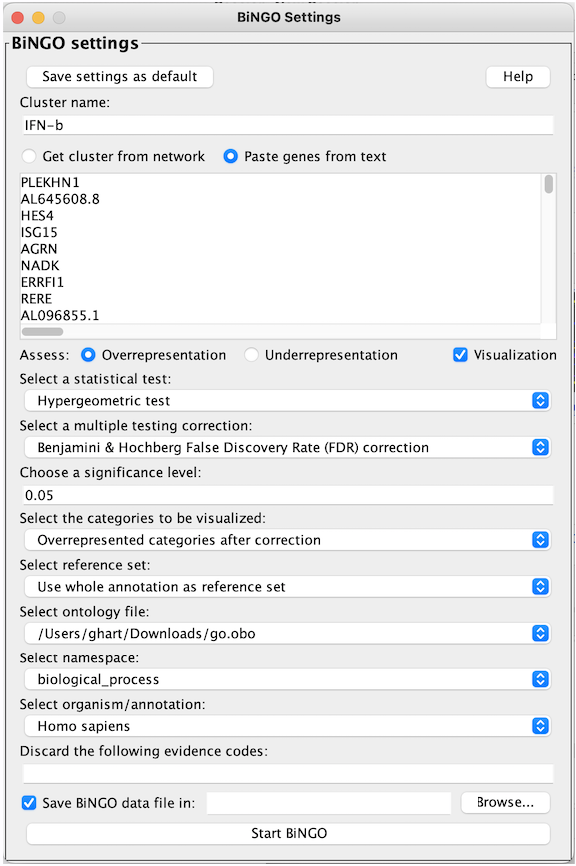

3. Enter **Cluster name**.
4. Select **Paste genes from text** and paste the gene list.
5. Under **Select ontology file**, use go.obo (taken from [here](http://current.geneontology.org/ontology/go.obo), accessed on 08JUN22).
6. Select parameters changed from default:
    1. **Select namespace:** biological_process
    2. **Select organism/annotation:** Homo sapiens
7. Enter desired folder in **Save BiNGO data file in**.
8. Click **Start BiNGO**. It will run, you may get errors that some genes can't be found (that's OK).
9. The graph should now show in the main window. Visualize with the Prefuse Force Directed Layout: in the menu bar, **Layout** → **Prefuse Force Directed Layout**.
10. Right click on the network in the left sidebar and select **Export as Network...**

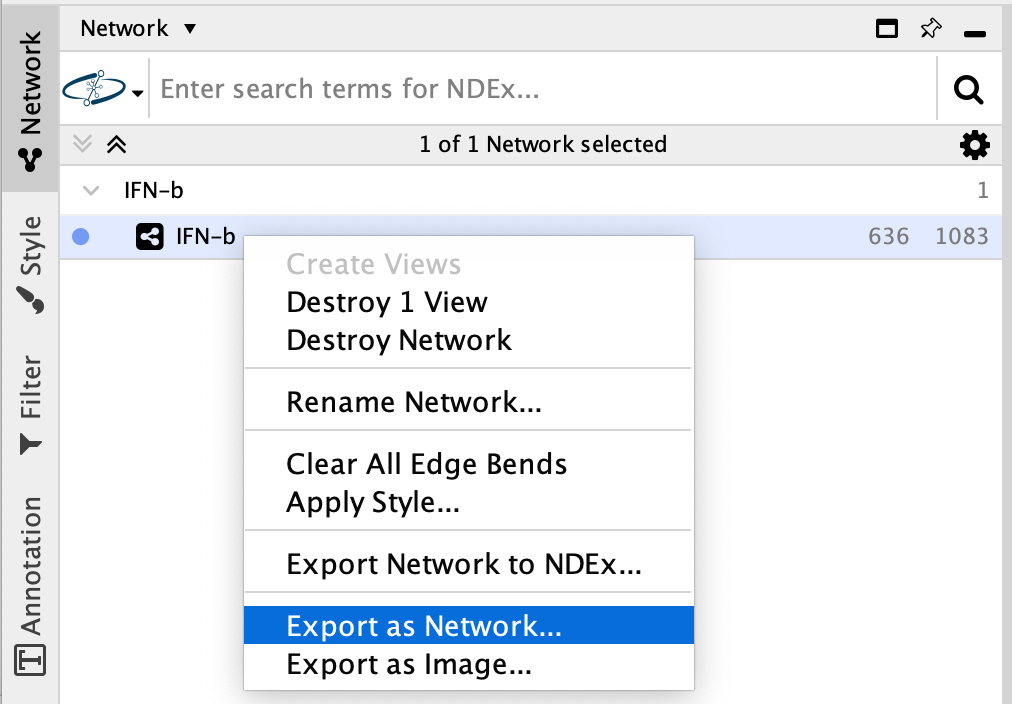

11. Export the network as a **Cytoscape.js JSON (*.cyjs)**.

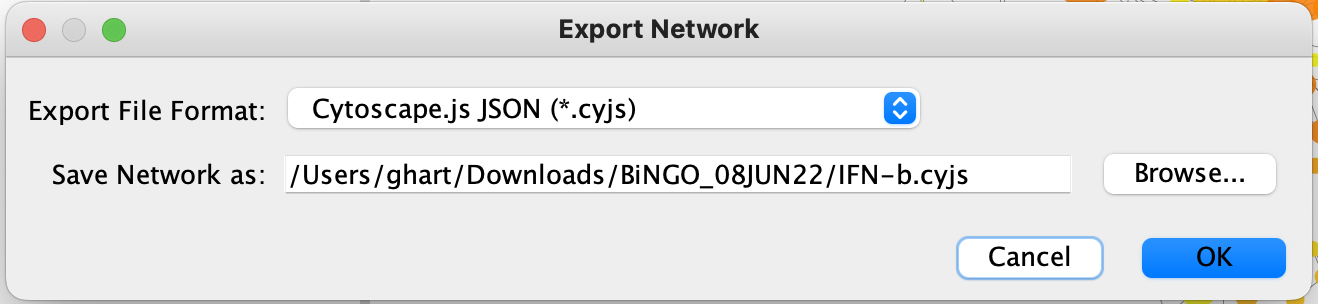

12. Repeat for IFN-g.

# Analyze BiNGO Outputs

In [21]:
def make_adj(edgelist):
    G = nx.convert_matrix.from_pandas_edgelist(edgelist)
    G.edges(data=True)
    adj = nx.to_pandas_adjacency(G)

    # sets the diagonal to 1 (node can't be connected to itself)
    adj[:] = adj.values + np.eye(adj.shape[0])
    return adj
    

def adata_from_bingonx(nx_name, path_to_cyjs, path_to_bgo):
    with open(path_to_cyjs, 'r') as file:
        node_json = json.load(file)

    obs = pd.concat([pd.Series(i['data']) for i in node_json['elements']['nodes']], axis=1).T.set_index('name')
    obs.index = obs.index.astype(str)
    X_umap = pd.DataFrame([i['position'] for i in node_json['elements']['nodes']])
    X_umap['y'] = -X_umap['y']
    
    with open(path_to_bgo, 'r') as file:
        for linenum, line in enumerate(file.readlines()):
            if line.startswith('GO-ID'):
                break
    
    bgo = pd.read_csv(path_to_bgo, sep='\t', skiprows=linenum).set_index('GO-ID')
    bgo.index = bgo.index.astype(str).astype('category')

    obs = obs.join(bgo)

    genes_list = [k.split('|') for k in bgo['Genes in test set']]
    genes_unique = np.unique([i for j in genes_list for i in j])

    bgo_genebool = pd.DataFrame(np.stack([[g in gl for g in genes_unique] for gl in genes_list]).T, index=genes_unique, columns=bgo.index).T
    bgo_genebool.index = bgo_genebool.index.astype(str)
    bgo_genebool = pd.concat([bgo_genebool, pd.DataFrame(False, index=np.setdiff1d(obs.index, bgo_genebool.index), columns=bgo_genebool.columns)])
    bgo_genebool = bgo_genebool.loc[obs.index].copy()


    var = bgo_genebool.columns.to_frame().drop(columns=[0])

    adata = sc.AnnData(X=bgo_genebool, var=var, obs=obs)
    adata.obsm['X_umap'] = X_umap.values # use the umap slot becuase it's easier, but maybe make a bingo slot later?
    
    adata.obs.columns = adata.obs.columns.str.replace('_%s$' % nx_name, '')
    
    numerical_cols = ['nodeSize', 'adjustedPValue', 'pValue']
    for numerical_col in numerical_cols:
        adata.obs[numerical_col] = adata.obs[numerical_col].astype(np.float)
    for cat_col in np.setdiff1d(adata.obs.columns, numerical_cols):
        adata.obs[cat_col] = adata.obs[cat_col].astype(str).astype('category')
        
    
    edges = pd.concat([pd.Series(i['data']) for i in node_json['elements']['edges']], axis=1).T
    adata.uns['edges'] = edges
    adj = make_adj(edges[['source', 'target']])
    adata.obsp['connectivities'] = adj.loc[obs['id'].values, obs['id'].values]
    
    return adata

In [22]:
adata0 = adata_from_bingonx('IFN_b', prefix_mrna + 'bingo/IFN-b.cyjs', prefix_mrna + 'bingo/IFN-b.bgo')
adata1 = adata_from_bingonx('IFN_g', prefix_mrna + 'bingo/IFN-g.cyjs', prefix_mrna + 'bingo/IFN-g.bgo')

## Visualize

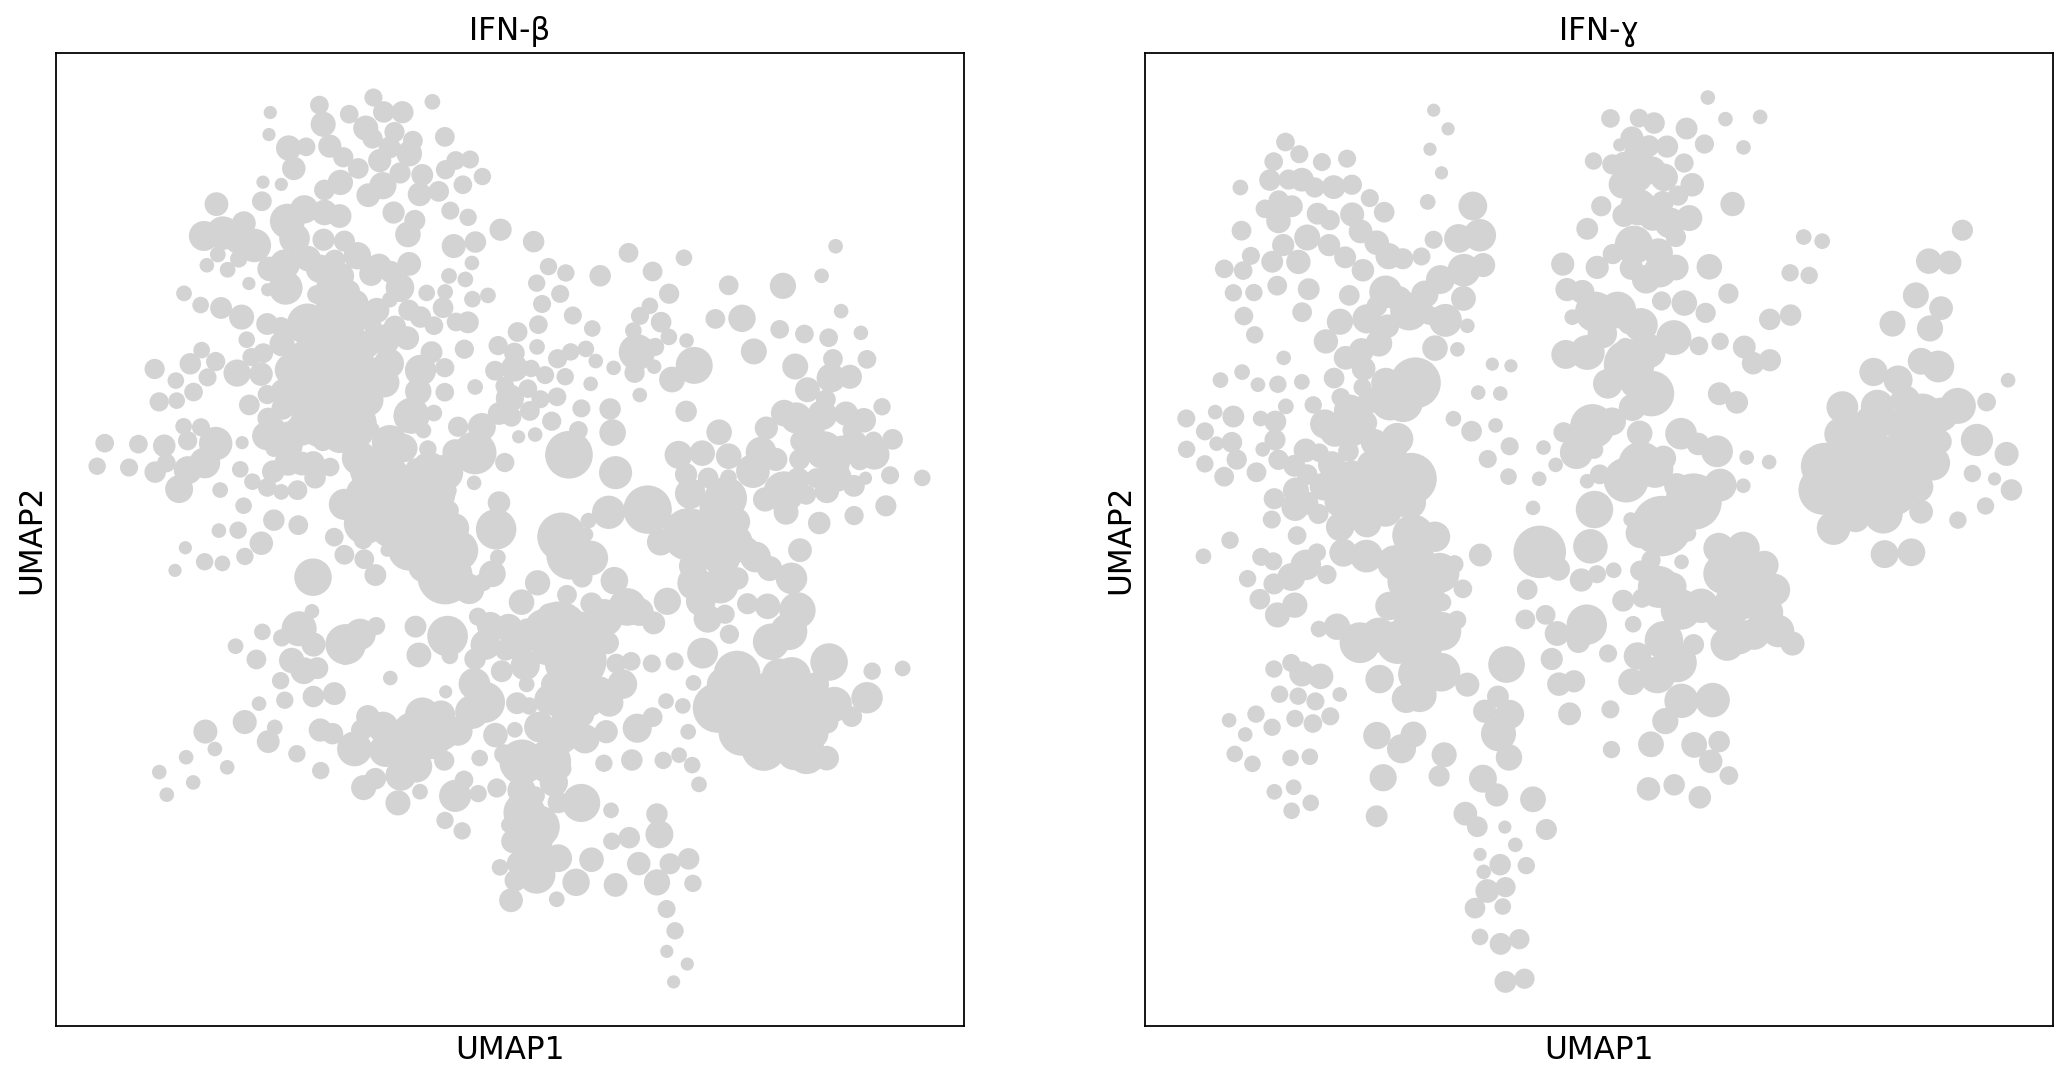

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sc.pl.umap(adata0, ax=ax[0], size=adata0.obs['nodeSize']*50, title='IFN-β', show=False, return_fig=False)
sc.pl.umap(adata1, ax=ax[1], size=adata1.obs['nodeSize']*50, title='IFN-ɣ', show=False, return_fig=False);

In [25]:
sc.tl.leiden(adata0, resolution=0.8, obsp='connectivities')
sc.tl.leiden(adata1, resolution=0.8, obsp='connectivities')

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


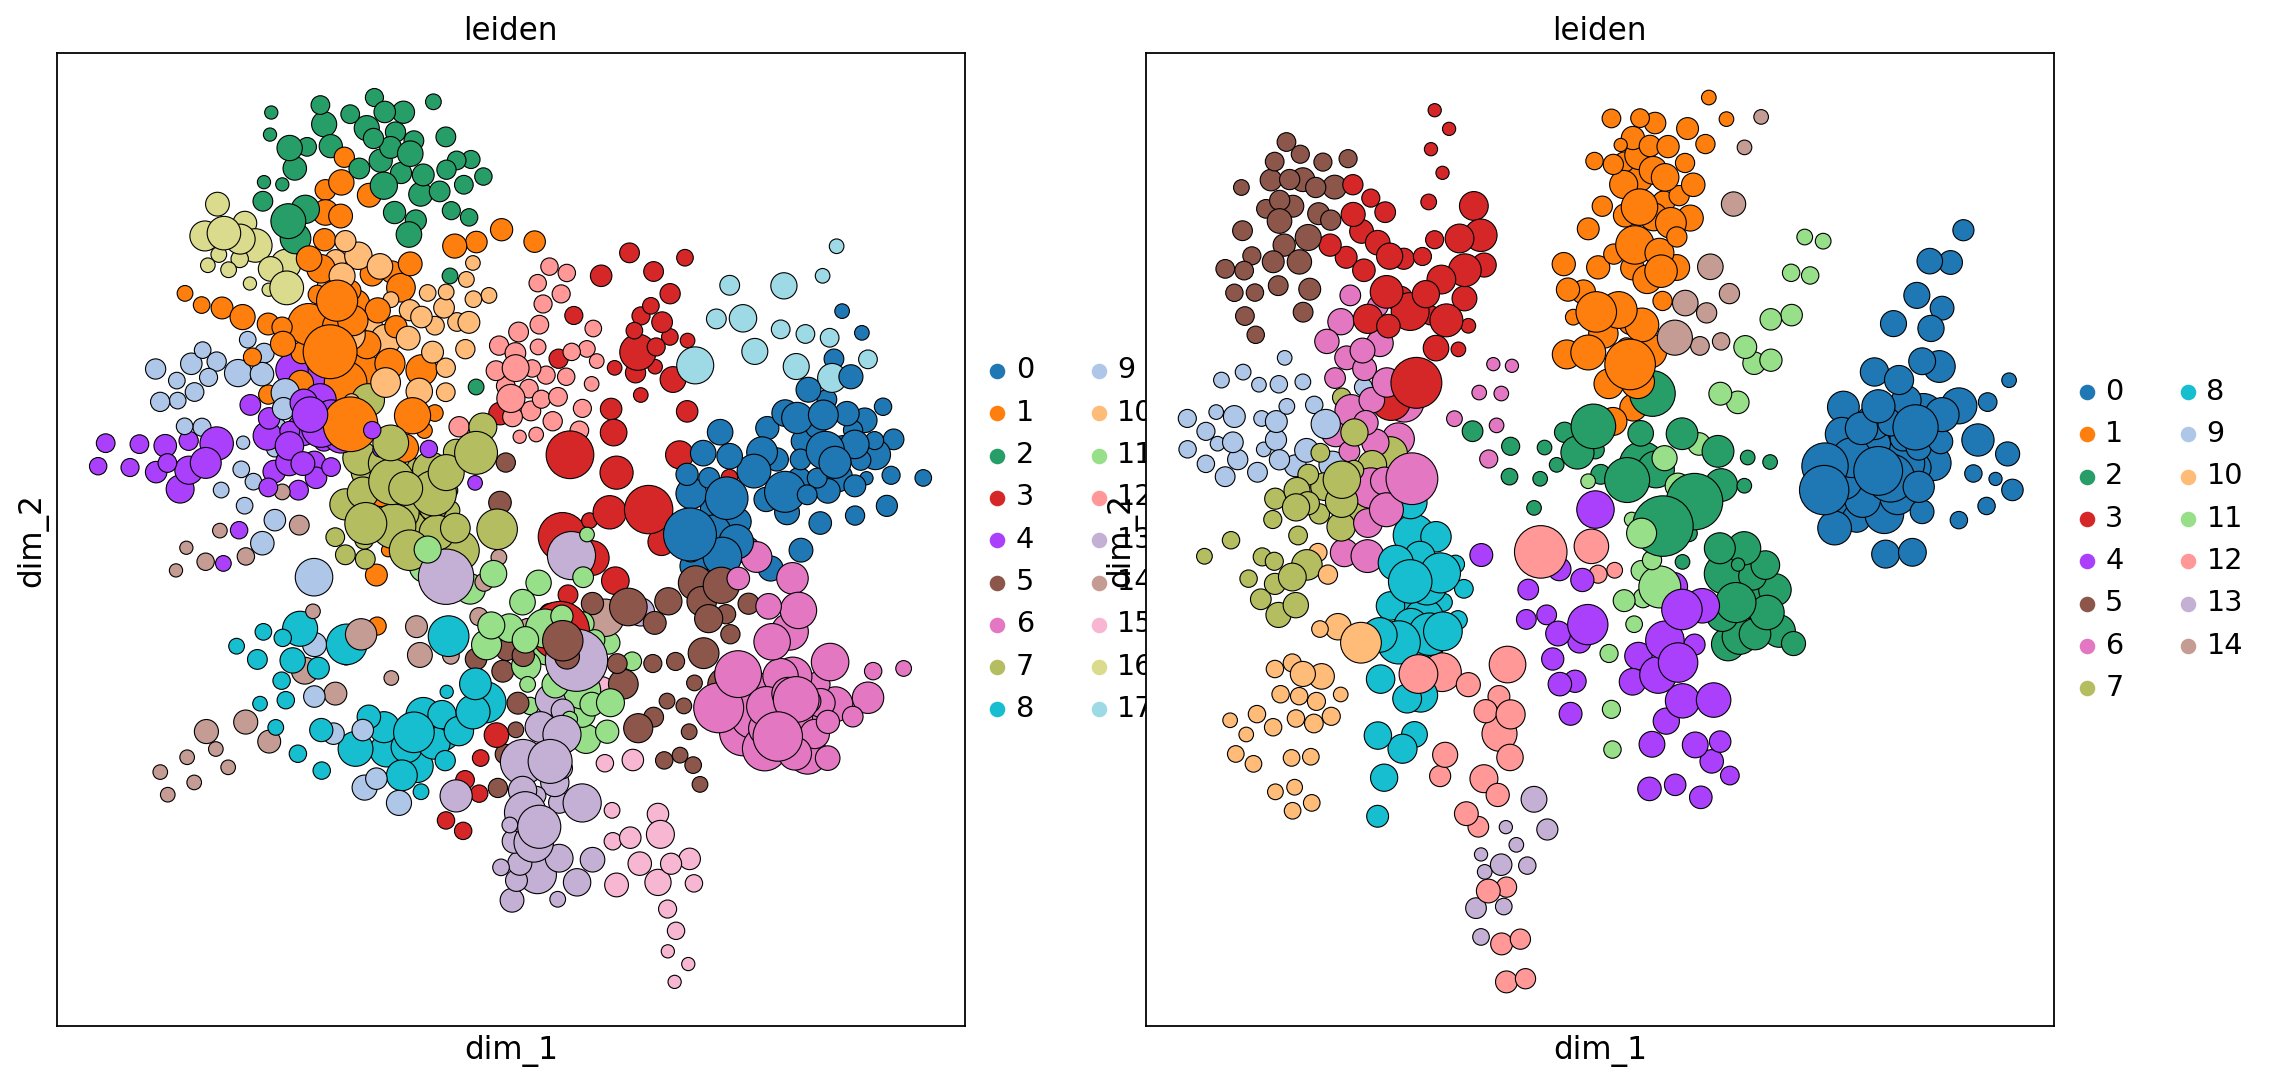

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0] = sc.pl.umap(adata0, ax=ax[0], size=adata0.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[1] = sc.pl.umap(adata1, ax=ax[1], size=adata1.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[0].set_xlabel('dim_1')
ax[0].set_ylabel('dim_2')
ax[1].set_xlabel('dim_1')
ax[1].set_ylabel('dim_2');

Filter to only those nodes that are significant. Make a copy now so that the Leiden clusters transfer over, because otherwise there are a bunch of totally unconnected nodes which get called as their own cluster.

In [27]:
adata0_sig = adata0[adata0.obs['adjustedPValue'] < 0.05].copy()
adata1_sig = adata1[adata1.obs['adjustedPValue'] < 0.05].copy()

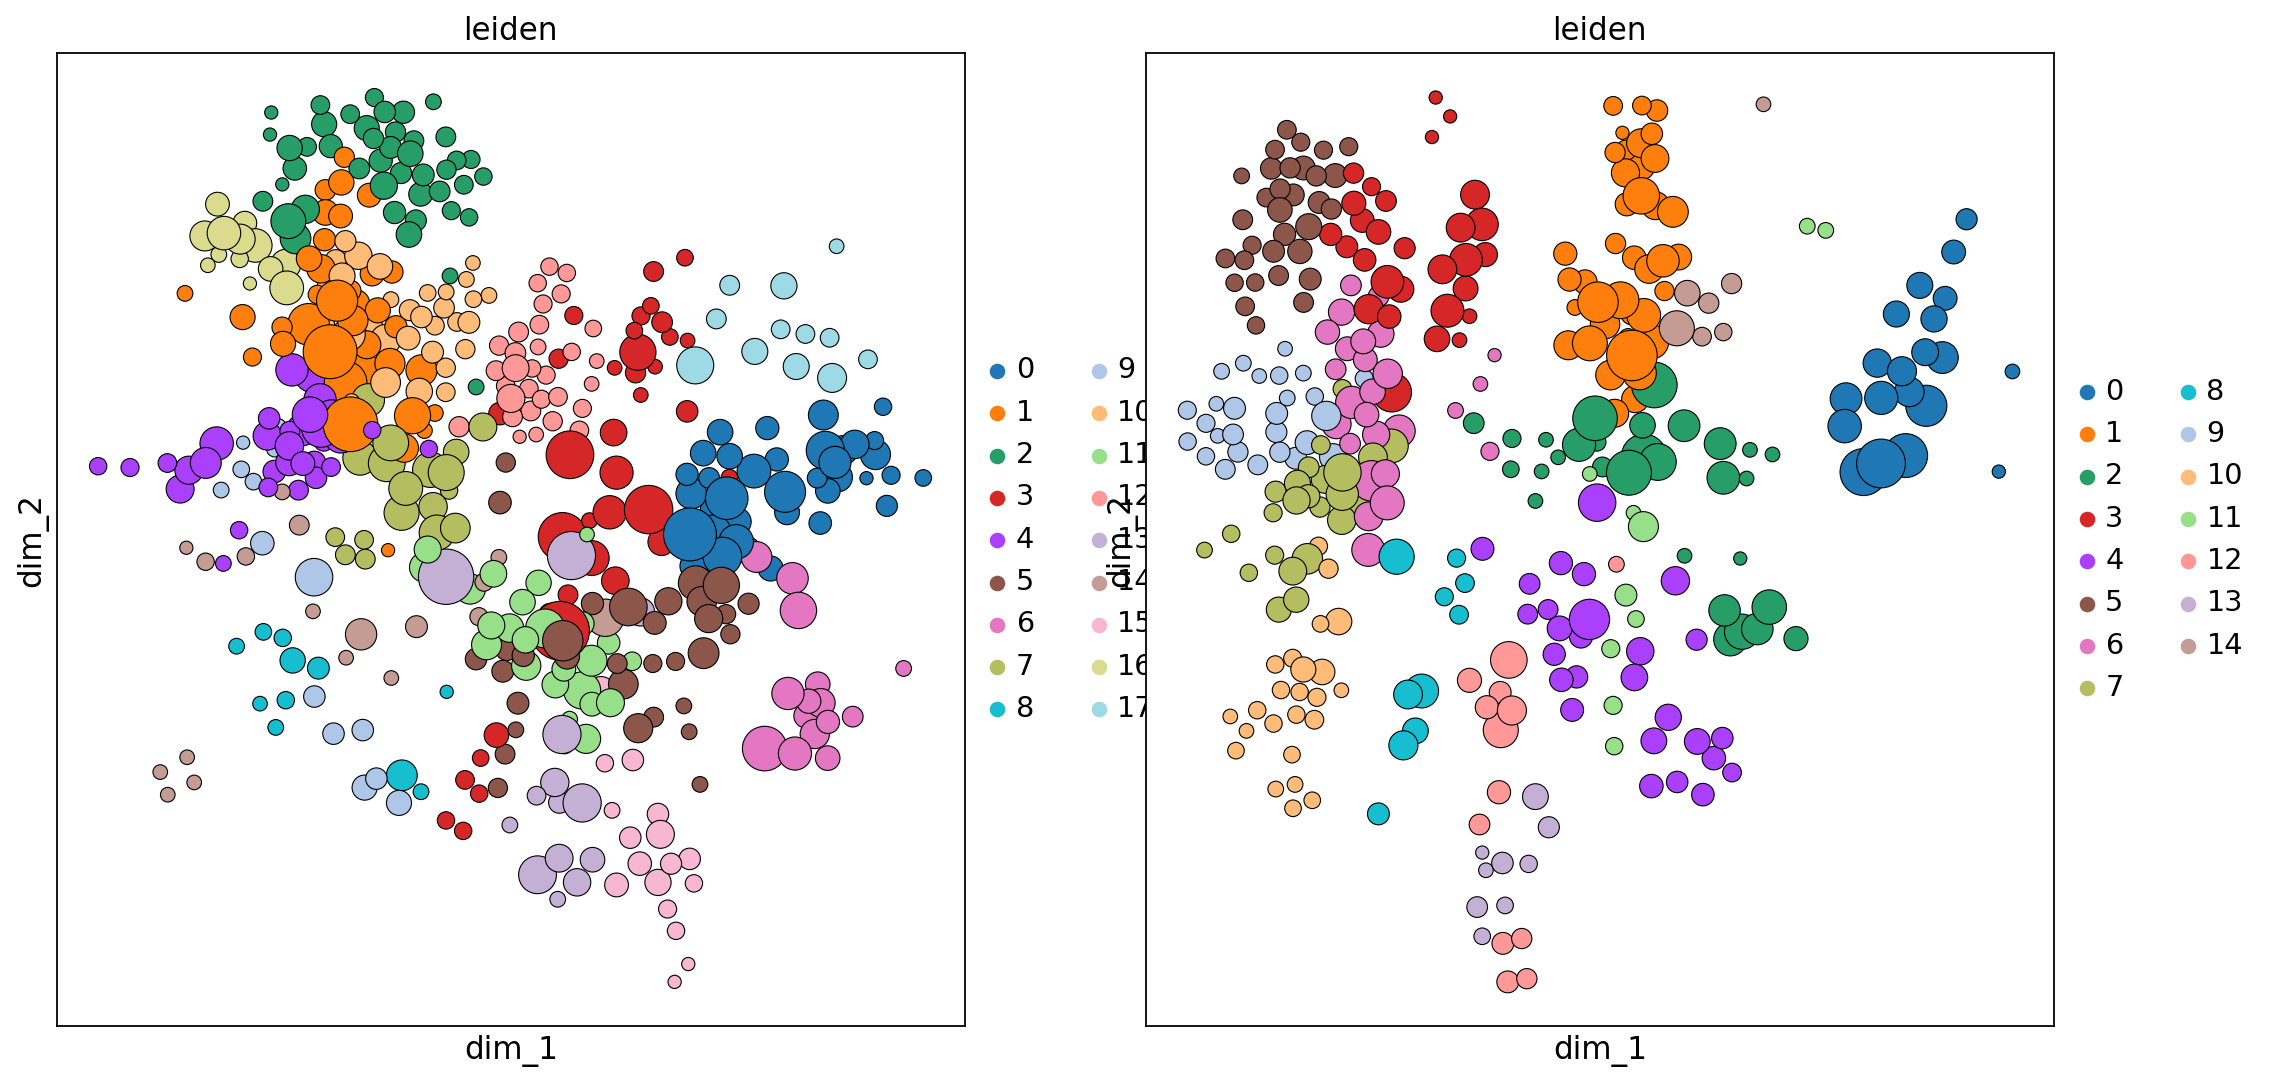

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0] = sc.pl.umap(adata0_sig, ax=ax[0], size=adata0_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[1] = sc.pl.umap(adata1_sig, ax=ax[1], size=adata1_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', linewidth=0.5, show=False, return_fig=False)
ax[0].set_xlabel('dim_1')
ax[0].set_ylabel('dim_2')
ax[1].set_xlabel('dim_1')
ax[1].set_ylabel('dim_2');

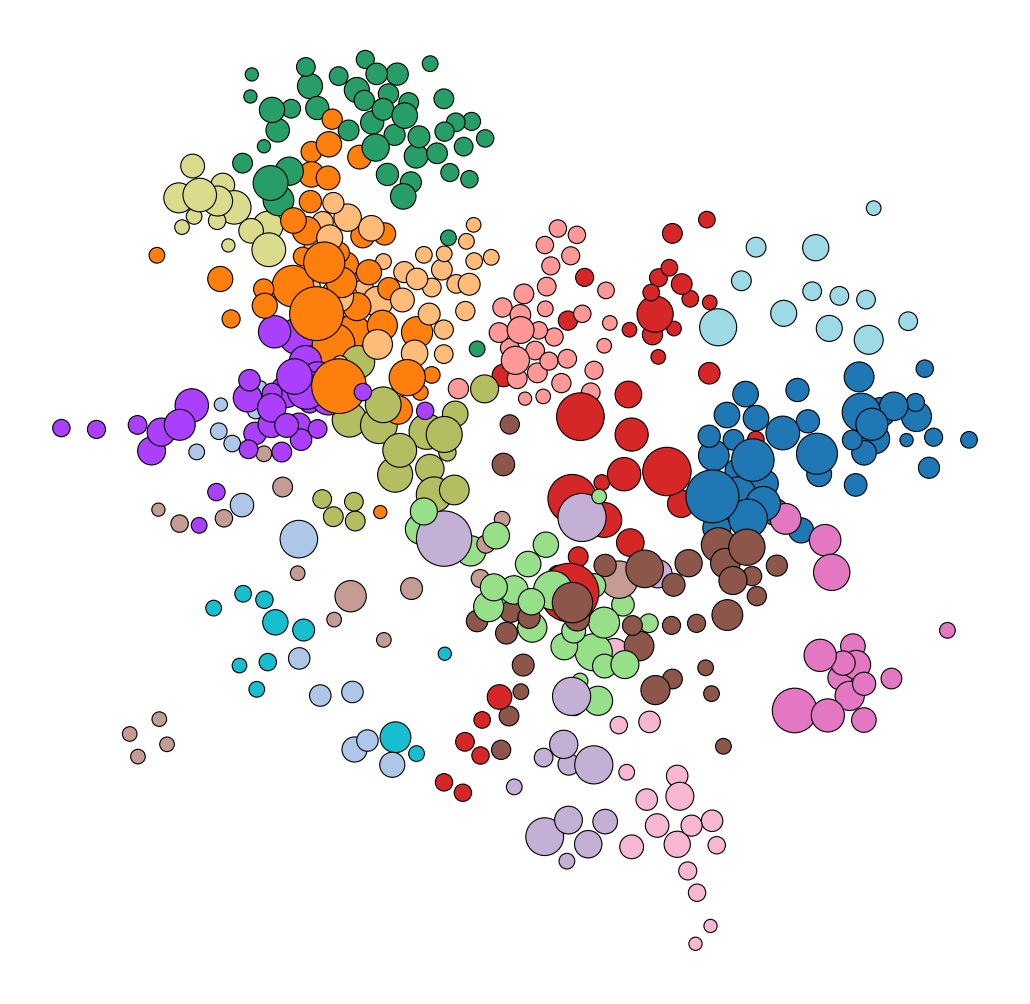

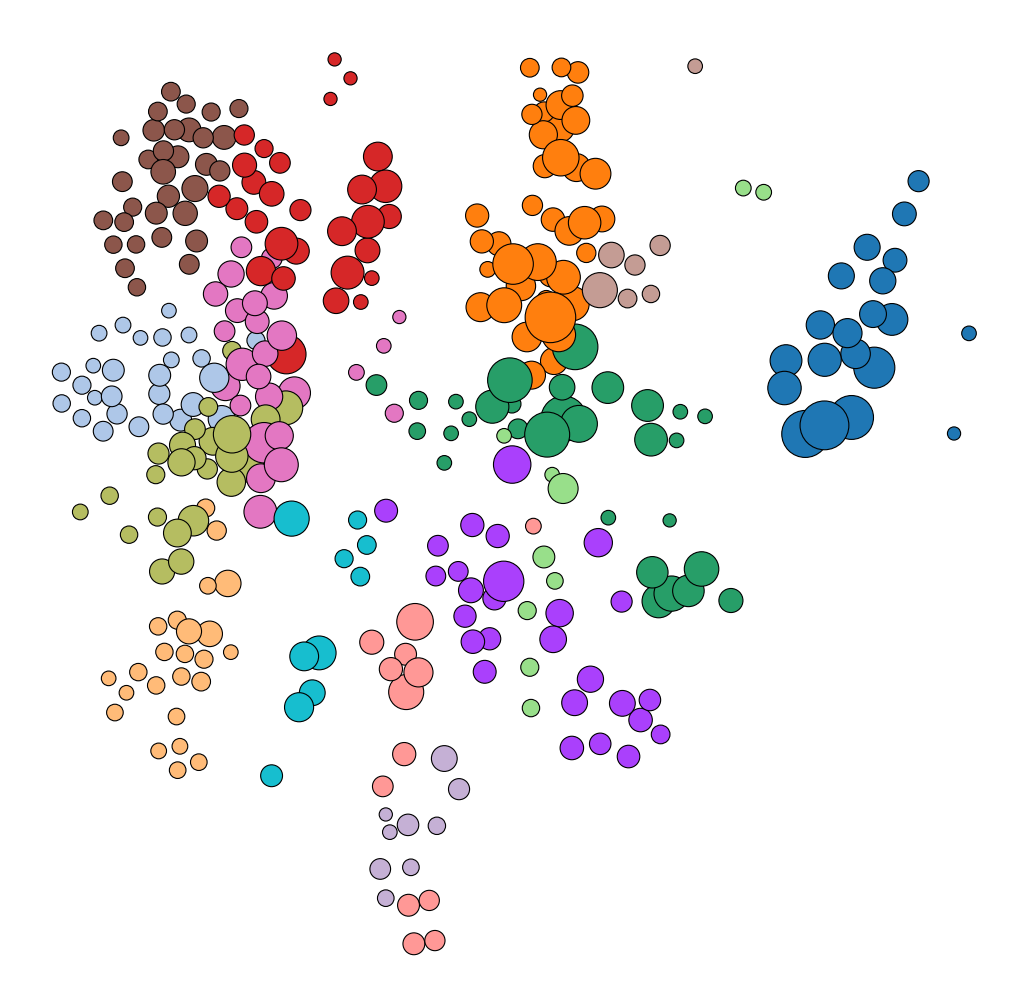

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = sc.pl.umap(adata0_sig, ax=ax, size=adata0_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', title='', frameon=False, legend_loc=None, linewidth=0.5, show=False, return_fig=False)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = sc.pl.umap(adata1_sig, ax=ax, size=adata1_sig.obs['nodeSize']*50, color='leiden', edgecolor='k', title='', frameon=False, legend_loc=None, linewidth=0.5, show=False, return_fig=False)

## Top Hits per Cluster

In [30]:
cond = 0

In [31]:
if cond == 0:
    top_hits = list()
    for clust in adata0_sig.obs['leiden'].cat.categories:
        top_hits.append(adata0_sig.obs[adata0_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').iloc[:3])
    top_hits_df = pd.concat(top_hits, axis=0, keys=adata0_sig.obs['leiden'].cat.categories)
#     top_hits_df.to_excel(prefix_mrna + 'bingo/top_hits_IFNb.xlsx') # requires openpyxl
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        display(top_hits_df)
elif cond == 1:
    top_hits = list()
    for clust in adata1_sig.obs['leiden'].cat.categories:
        top_hits.append(adata1_sig.obs[adata1_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').iloc[:3])
    top_hits_df = pd.concat(top_hits, axis=0, keys=adata1_sig.obs['leiden'].cat.categories)
#     top_hits_df.to_excel(prefix_mrna + 'bingo/top_hits_IFNg.xlsx') # requires openpyxl
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        display(top_hits_df)

description  \
   name                                                                               
0  50896  response to stimulus                                                        
   9607   response to biotic stimulus                                                 
   43207  response to external biotic stimulus                                        
1  51239  regulation of multicellular organismal process                              
   48522  positive regulation of cellular process                                     
   50789  regulation of biological process                                            
2  51249  regulation of lymphocyte activation                                         
   70663  regulation of leukocyte proliferation                                       
   51251  positive regulation of lymphocyte activation                                
3  7154   cell communication                                                          
   7165   signal transduction                                                         
   51716  cellular response to stimulus                                               
4  43123  positive regulation of I-kappaB kinase/NF-kappaB signaling                  
   43122  regulation of I-kappaB kinase/NF-kappaB signaling                           
   48584  positive regulation of response to stimulus                                 
5  2376   immune system process                                                       
   6955   immune response                                                             
   6952   defense response                                                            
6  16553  base conversion or substitution editing                                     
   44265  cellular macromolecule catabolic process                                    
   46700  heterocycle catabolic process                                               
7  10628  positive regulation of gene expression                                      
   51246  regulation of protein metabolic process                                     
   45428  regulation of nitric oxide biosynthetic process                             
8  17121  plasma membrane phospholipid scrambling                                     
   34204  lipid translocation                                                         
   97035  regulation of membrane lipid distribution                                   
9  51900  regulation of mitochondrial depolarization                                  
   7204   positive regulation of cytosolic calcium ion concentration                  
   3254   regulation of membrane depolarization                                       
10 2682   regulation of immune system process                                         
   50776  regulation of immune response                                               
   2684   positive regulation of immune system process                                
11 51091  positive regulation of DNA-binding transcription factor activity            
   65009  regulation of molecular function                                            
   51092  positive regulation of NF-kappaB transcription factor activity              
12 1819   positive regulation of cytokine production                                  
   1817   regulation of cytokine production                                           
   32735  positive regulation of interleukin-12 production                            
13 23052  signaling                                                                   
   65007  biological regulation                                                       
   2520   immune system development                                                   
14 44419  biological process involved in interspecies interaction between organisms   
   50792  regulation of viral process                                                 
   42592  homeostatic process                                         

## Jaccard Index of Enriched Terms

In [32]:
clusts0, clusts1 = adata0_sig.obs['leiden'].cat.categories, adata1_sig.obs['leiden'].cat.categories
jaccard_desc_df = pd.DataFrame(0, index=clusts0, columns=clusts1)
for clust0, clust1 in tqdm(it.product(clusts0, clusts1)):
    desc0 = adata0_sig.obs[adata0_sig.obs['leiden'] == clust0]['description'].values
    desc1 = adata1_sig.obs[adata1_sig.obs['leiden'] == clust1]['description'].values
    jaccard_desc_df.loc[clust0, clust1] = np.intersect1d(desc0, desc1).shape[0]/np.union1d(desc0, desc1).shape[0]

0it [00:00, ?it/s]

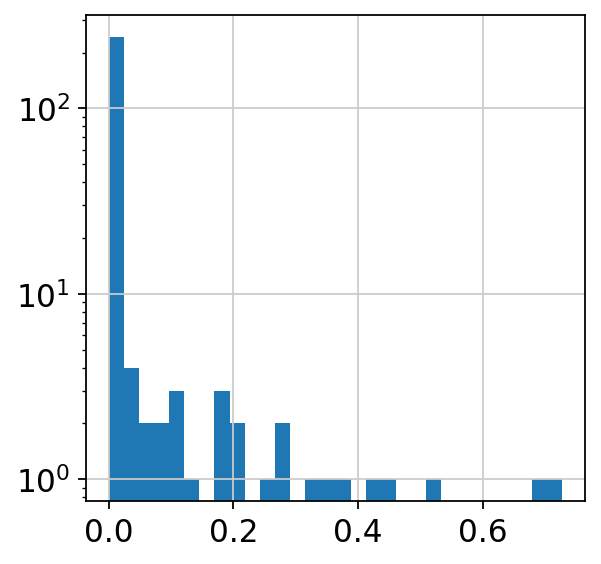

In [33]:
plt.hist(jaccard_desc_df.values.flatten(), bins=30);
plt.yscale('log');

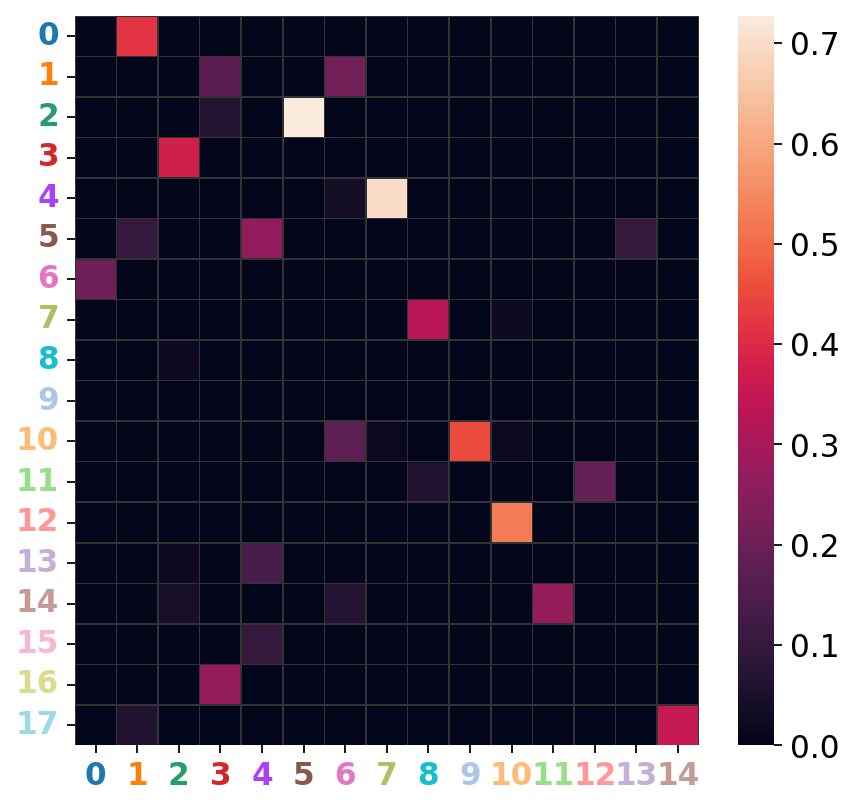

In [34]:
plt.figure(figsize=(6.25, 6))
ax = sns.heatmap(jaccard_desc_df, linewidth=0.25, linecolor='#333333')
yticklabels = ax.set_yticklabels(clusts0, rotation=0, fontdict={'weight':'bold'})
for yticklabel, c in zip(yticklabels, adata0.uns['leiden_colors']):
    yticklabel.set_color(c)
    
xticklabels = ax.set_xticklabels(clusts1, rotation=0, fontdict={'weight':'bold'})
for xticklabel, c in zip(xticklabels, adata1.uns['leiden_colors']):
    xticklabel.set_color(c)

## Explore BiNGO Gene Ontology Clusters

Here I use the following functions to explore the results from BiNGO. I re-run the cells several times with different comparisons and different clusters to help me write the text.

### Define Functions

In [35]:
def compare_clusts(compare, names=None):
    if type(names) == type(None):
        names = 'cond0', 'cond1'
    # compare = (cond0_clust, cond1_clust)
    df0 = adata0_sig.obs[adata0_sig.obs['leiden'] == compare[0]][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
    df1 = adata1_sig.obs[adata1_sig.obs['leiden'] == compare[1]][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        display(pd.concat([df0, df1], axis=1, keys=names))
    return

def display_clust(cond, clust):
    if cond == 0:    
        df = adata0_sig.obs[adata0_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
        with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
            display(df)
    elif cond == 1:
        df = adata1_sig.obs[adata1_sig.obs['leiden'] == clust][['description', 'adjustedPValue']].sort_values(by='adjustedPValue').reset_index()
        with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
            display(df)
    return

def display_desc(cond, clust):
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        if cond == 0:
            df = adata0_sig.obs[adata0_sig.obs['description'].isin(np.intersect1d(adata0_sig.obs[adata0_sig.obs['leiden'] == clust]['description'], adata0_sp))][['description', 'adjustedPValue']].sort_values(by='adjustedPValue')
            display(df)
        elif cond == 1:
            df = adata1_sig.obs[adata1_sig.obs['description'].isin(np.intersect1d(adata1_sig.obs[adata1_sig.obs['leiden'] == clust]['description'], adata1_sp))][['description', 'adjustedPValue']].sort_values(by='adjustedPValue')
            display(df)
    return

def show_feature(adata, feature, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sc.pl.umap(adata, ax=ax, size=adata.obs['nodeSize']*50, color=feature, edgecolor='k', linewidth=0.5, show=False, return_fig=False)
    ax.set_xlabel('dim_1')
    ax.set_ylabel('dim_2')
    return ax

def get_genes(adata, clust):
    print(adata.var[adata[adata.obs['leiden'] == clust].X.any(0)].index.tolist())
    return

def GO_de_genes(cond, GO_id, p=False, disp=True):
    l0, l1, p0, p1 = decomp_mrna.cols
    if cond == 0:
        print(adata0_sig.obs.loc[focus_GO, 'description'])
        genes = adata0_sig.obs.loc[focus_GO]['Genes in test set'].split('|')
        genes = np.intersect1d(decomp_mrna.df.index.values, genes) # this is to fix the "orf" issue, BINGO returning genes all capitalized
        if p:
            dem_focusgo = decomp_mrna.df.loc[genes].sort_values(by=p0)
        else:
            dem_focusgo = decomp_mrna.df.loc[genes].sort_values(by=l0, ascending=False)
        if disp:
            display(dem_focusgo)
    elif cond == 1:
        print(adata1_sig.obs.loc[focus_GO, 'description'])
        genes = adata1_sig.obs.loc[focus_GO]['Genes in test set'].split('|')
        genes = np.intersect1d(decomp_mrna.df.index.values, genes) # this is to fix the "orf" issue, BINGO returning genes all capitalized
        if p:
            dem_focusgo = decomp_mrna.df.loc[genes].sort_values(by=p1)
        else:
            dem_focusgo = decomp_mrna.df.loc[genes].sort_values(by=l1, ascending=False)
        if disp:
            display(dem_focusgo)
    return dem_focusgo

def check_string(cond, string):
    if cond == 0:
        print(adata0_sig.obs['description'].str.contains(string).sum())
        display(adata0_sig.obs[adata0_sig.obs['description'].str.contains(string)][['description', 'adjustedPValue']].sort_values(by='adjustedPValue'))
    elif cond == 1:
        print(adata1_sig.obs['description'].str.contains(string).sum())
        display(adata1_sig.obs[adata1_sig.obs['description'].str.contains(string)][['description', 'adjustedPValue']].sort_values(by='adjustedPValue'))
    return

### Comparisons

In [36]:
adata0_sp = np.setdiff1d(adata0_sig.obs['description'], adata1_sig.obs['description'])
adata1_sp = np.setdiff1d(adata1_sig.obs['description'], adata0_sig.obs['description'])
shared = np.intersect1d(adata1_sig.obs['description'], adata0_sig.obs['description'])

In [37]:
compare = ('2', '5')
compare_clusts(compare, names=['beta', 'gamma'])

beta  \
       name   
0   51249     
1   70663     
2   51251     
3   50670     
4   32944     
5   30888     
6   50863     
7   70665     
8   50671     
9   50870     
10  32946     
11  45621     
12  45582     
13  30890     
14  42127     
15  45580     
16  50871     
17  45619     
18  50864     
19  8284      
20  42129     
21  43372     
22  2000516   
23  43370     
24  2000514   
25  46637     
26  46638     
27  46634     
28  46635     
29  50868     
30  51250     
31  42102     
32  48660     
33  50672     
34  70664     
35  32945     
36  42130     
37  8285      
38  70668     
39  33689     
40  70666     
41  31294     
42  46640     
43  31295     

                                                                            \
                                                               description   
0   regulation of lymphocyte activation                                      
1   regulation of leukocyte proliferation                                    
2   positive regulation of lymphocyte activation                             
3   regulation of lymphocyte proliferation                                   
4   regulation of mononuclear cell proliferation                             
5   regulation of B cell proliferation                                       
6   regulation of T cell activation                                          
7   positive regulation of leukocyte proliferation                           
8   positive regulation of lymphocyte proliferation                          
9   positive regulation of T cell activation                                 
10  positive regulation of mononuclear cell proliferation                    
11  positive regulation of lymphocyte differentiation                        
12  positive regulation of T cell differentiation                            
13  positive regulation of B cell proliferation                              
14  regulation of cell population proliferation                              
15  regulation of T cell differentiation                                     
16  positive regulation of B cell activation                                 
17  regulation of lymphocyte differentiation                                 
18  regulation of B cell activation                                          
19  positive regulation of cell population proliferation                     
20  regulation of T cell proliferation                                       
21  positive regulation of CD4-positive, alpha-beta T cell differentiation   
22  positive regulation of CD4-positive, alpha-beta T cell activation        
23  regulation of CD4-positive, alpha-beta T cell differentiation            
24  regulation of CD4-positive, alpha-beta T cell activation                 
25  regulation of alpha-beta T cell differentiation                          
26  positive regulation of alpha-beta T cell differentiation                 
27  regulation of alpha-beta T cell activation                               
28  positive regulation of alpha-beta T cell activation                      
29  negative regulation of T cell activation                                 
30  negative regulation of lymphocyte activation                             
31  positive regulation of T cell proliferation                              
32  regulation of smooth muscle cell proliferation                           
33  negative regulation of lymphocyte proliferation                          
34  negative regulation of leukocyte proliferation                           
35  negative regulation of mononuclear cell proliferation                    
36  negative regulation of T cell proliferation                              
37  negative regulation of cell population proliferation                     
38  positive regulation of mast cell proliferation                           
39  negative regulation of osteoblast proliferation                          
40  regulation of mast cell proliferatio

### Individual Cluster Outputs

In [38]:
cond = 0
clust = '11'
display_clust(cond, clust)

name                                                       description  \
0   51091  positive regulation of DNA-binding transcription factor activity   
1   65009  regulation of molecular function                                   
2   51092  positive regulation of NF-kappaB transcription factor activity     
3   44093  positive regulation of molecular function                          
4   51090  regulation of DNA-binding transcription factor activity            
5   50790  regulation of catalytic activity                                   
6   31399  regulation of protein modification process                         
7   45937  positive regulation of phosphate metabolic process                 
8   10562  positive regulation of phosphorus metabolic process                
9   42327  positive regulation of phosphorylation                             
10  19220  regulation of phosphate metabolic process                          
11  51174  regulation of phosphorus metabolic process                         
12  42325  regulation of phosphorylation                                      
13  33674  positive regulation of kinase activity                             
14  42976  activation of Janus kinase activity                                
15  1932   regulation of protein phosphorylation                              
16  43549  regulation of kinase activity                                      
17  31401  positive regulation of protein modification process                
18  1934   positive regulation of protein phosphorylation                     
19  10922  positive regulation of phosphatase activity                        
20  43085  positive regulation of catalytic activity                          
21  10921  regulation of phosphatase activity                                 
22  51347  positive regulation of transferase activity                        
23  43393  regulation of protein binding                                      
24  51336  regulation of hydrolase activity                                   

    adjustedPValue  
0   0.000001        
1   0.000001        
2   0.000004        
3   0.000045        
4   0.000060        
5   0.000217        
6   0.001981        
7   0.003435        
8   0.003435        
9   0.007132        
10  0.007544        
11  0.007775        
12  0.009067        
13  0.013901        
14  0.016220        
15  0.016220        
16  0.016636        
17  0.022543        
18  0.025116        
19  0.025388        
20  0.029518        
21  0.033574        
22  0.040067        
23  0.044617        
24  0.047202

In [39]:
get_genes(adata0_sig, '4')

['ADA', 'ADRB2', 'AES', 'AIDA', 'AKAP7', 'APOBEC3F', 'APOBEC3G', 'APOL3', 'ARHGEF10L', 'ARHGEF11', 'ARHGEF3', 'BIRC2', 'BMPR2', 'BST2', 'C1QA', 'C1QB', 'C2', 'C5', 'CACNA1A', 'CALCRL', 'CARD11', 'CASP1', 'CASP10', 'CASP8', 'CBLB', 'CCL2', 'CCL5', 'CD38', 'CD40', 'CD40LG', 'CD74', 'CD80', 'CD86', 'CDKN1C', 'CFB', 'CFD', 'CFLAR', 'CHMP5', 'CIR1', 'CXCL10', 'CXCL12', 'CYTH1', 'DDX58', 'DISC1', 'DYNLT1', 'EDN1', 'ELF1', 'EPHB2', 'ERRFI1', 'FARP2', 'FASLG', 'FGD2', 'GIMAP5', 'GNAI3', 'GRIN3A', 'HLX', 'HMOX1', 'HSP90AB1', 'HSPD1', 'IDO1', 'IGF1', 'IKBKE', 'IL10', 'IL15', 'IL1RN', 'IL27', 'IL7R', 'INPP5D', 'IQGAP2', 'ITGA2', 'ITSN1', 'JAK2', 'JUP', 'KITLG', 'KLHL6', 'LAG3', 'LAP3', 'LGALS9', 'LITAF', 'LRP5', 'LYN', 'MALT1', 'MAPK8IP2', 'MICB', 'MIER1', 'MPP1', 'MYD88', 'NLK', 'NOD1', 'NOD2', 'OGA', 'P2RX4', 'P2RX7', 'PELI1', 'PLA2G4A', 'PLEK', 'PML', 'PRLR', 'PSD4', 'PSEN2', 'PTK2B', 'RAB8B', 'RASGEF1B', 'RASGRP3', 'RBCK1', 'RELA', 'RGL1', 'RHOC', 'RICTOR', 'RIPK1', 'RIPK2', 'SAMHD1', 'SECTM1

In [40]:
cond = 0
clust = '15'
display_desc(cond, clust)

description  adjustedPValue
name                                                 
32943  mononuclear cell proliferation  0.000006      
70661  leukocyte proliferation         0.000009      
46651  lymphocyte proliferation        0.000019      
8283   cell population proliferation   0.001305      
30217  T cell differentiation          0.001314      
42100  B cell proliferation            0.001417      
42113  B cell activation               0.007172      
45058  T cell selection                0.007294      
42098  T cell proliferation            0.007628      
46631  alpha-beta T cell activation    0.016702      
45061  thymic T cell selection         0.035984      
1866   NK T cell proliferation         0.046205      
51132  NK T cell activation            0.046205

### Highlight Particular Genes

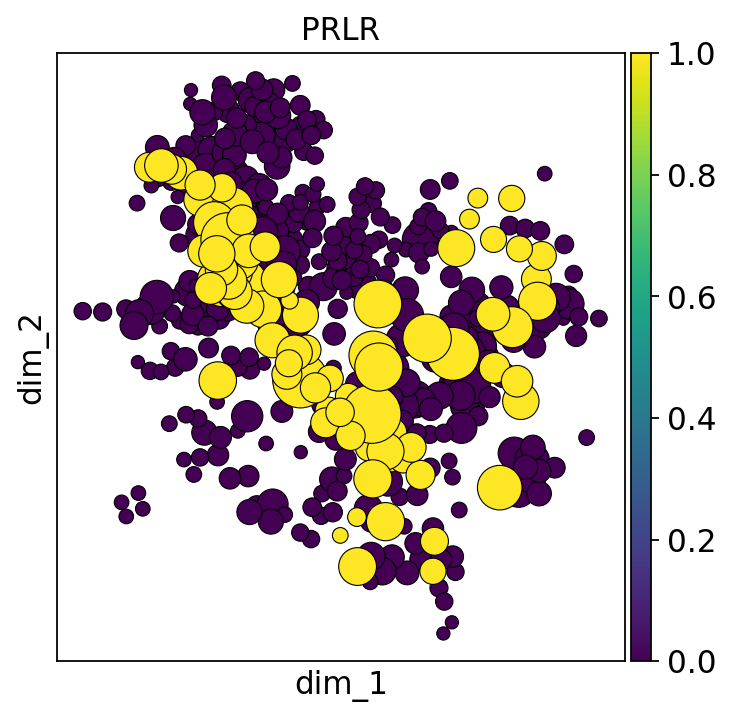

In [41]:
show_feature(adata0_sig, 'PRLR', figsize=(5, 5));

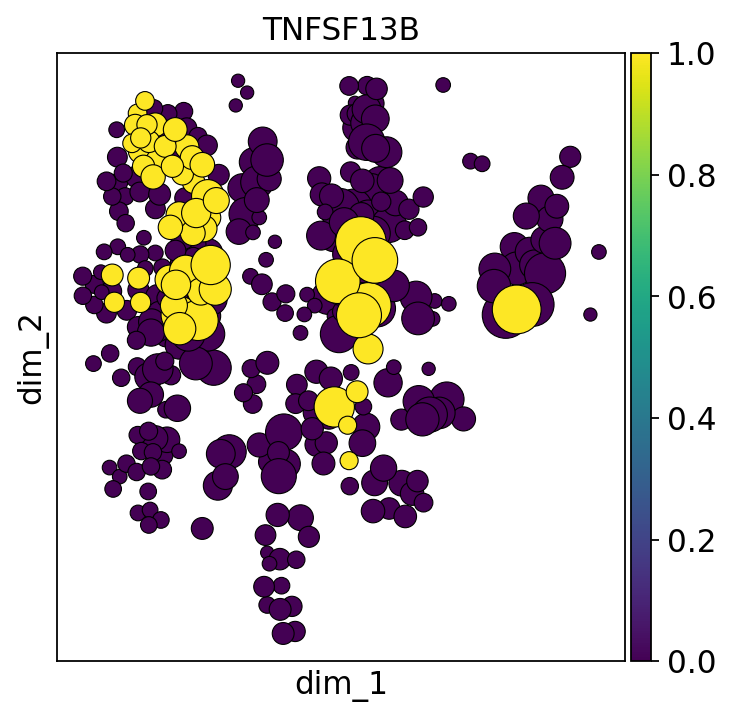

In [42]:
show_feature(adata1_sig, 'TNFSF13B', figsize=(5, 5));

### Individual GO Term Outputs

In [43]:
cond = 1
string = 'NF'
check_string(cond, string)

4


description  adjustedPValue
name                                                                    
43123  positive regulation of I-kappaB kinase/NF-kapp...    5.943000e-07
43122  regulation of I-kappaB kinase/NF-kappaB signaling    1.163600e-06
51092  positive regulation of NF-kappaB transcription...    3.607100e-05
7249                 I-kappaB kinase/NF-kappaB signaling    7.990700e-03

In [44]:
cond = 0
focus_GO = '45058'
df_focusgo = GO_de_genes(cond, focus_GO)

T cell selection


lB            pB        lG            pG
IL15    2.100346  1.243519e-24  2.423199  2.079158e-34
CD74    0.869034  2.813149e-03  2.611979  8.597379e-24
SPN     0.785813  3.669676e-06  0.227919  2.839402e-01
BCL2    0.578708  2.865962e-03  0.204491  3.651086e-01
CARD11  0.566275  1.243785e-02  0.418482  1.112381e-01
ZAP70   0.518807  9.400020e-03  0.334585  1.556322e-01

Bubble plot params added to DECompare.bubble


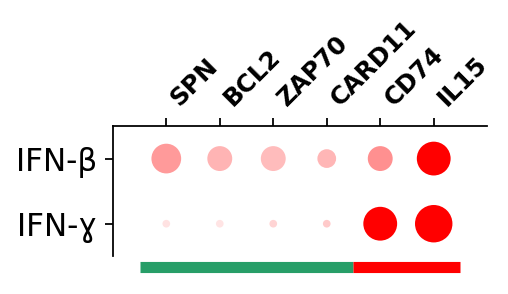

In [45]:
sig_params = {
    'bins': [5e-2, 1e-2, 1e-5, 1e-10, 1e-30, 1e-50],
    'dot_size_range': (0.3, 15)
}
decomp_mrna.plot_bubble(df_focusgo.index.values, focus_dx=focus_dx, sig_params=sig_params, protein=False);

### Shared GO Terms

In [46]:
df0 = adata0_sig.obs[adata0_sig.obs['description'].isin(shared)][['description', 'adjustedPValue', 'leiden']].set_index('description', drop=True)
df1 = adata1_sig.obs[adata1_sig.obs['description'].isin(shared)][['description', 'adjustedPValue', 'leiden']].set_index('description', drop=True)
df_joined = df0.join(df1, lsuffix='-0', rsuffix='-1')
pvalcols = ['adjustedPValue-0', 'adjustedPValue-1']
df_joined[pvalcols] = -np.log10(df_joined[pvalcols])

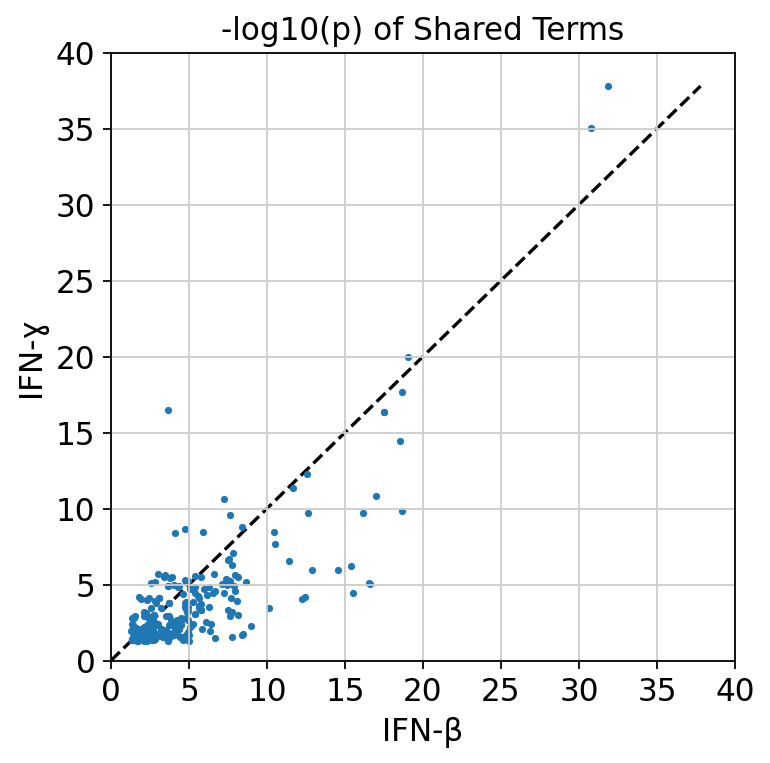

In [47]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
ax.set_title('-log10(p) of Shared Terms')
x, y = df_joined[pvalcols].values.T
maxlim = max(x.max(), y.max())
ax.plot([0, maxlim], [0, maxlim], linestyle='--', color='k', zorder=0)
ax.scatter(x, y, s=5);
ax = nrutils.id_axes(ax, lim=(0, 40))
ax.set_xlabel('IFN-β')
ax.set_ylabel('IFN-ɣ');

# Analyze SCENIC Results

## Create UMAP from AUCell

In [51]:
counts = sc.read_h5ad(prefix_mrna + 'scenic/raw_counts.h5ad')

In [51]:
aucell_df = pd.read_csv(prefix_mrna + 'scenic/aucell_output.csv', index_col=0)
aucell = sc.AnnData(aucell_df)

In [7]:
sc.pp.normalize_total(aucell, target_sum=10)

normalizing counts per cell
    finished (0:00:00)


In [8]:
sc.pp.scale(aucell, max_value=10)

    ... clipping at max_value 10


In [9]:
sc.tl.pca(aucell, n_comps=100)

computing PCA
    with n_comps=100
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


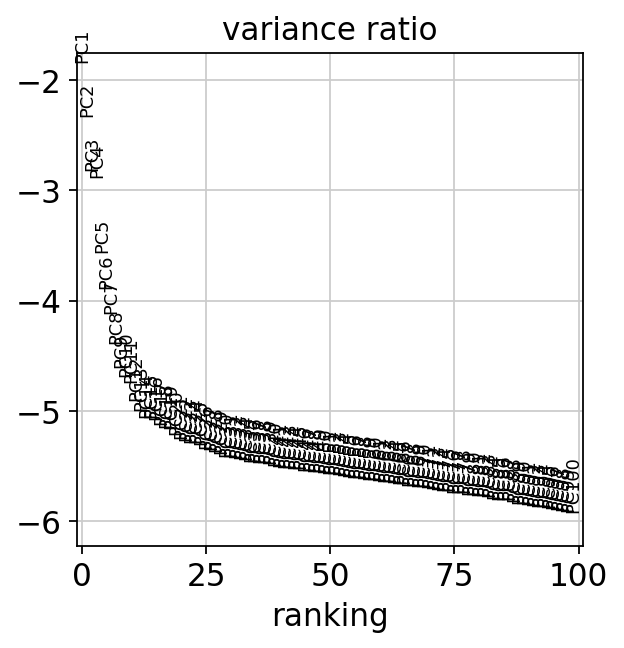

In [10]:
sc.pl.pca_variance_ratio(aucell, n_pcs=100, log=True)

In [ ]:
sc.pp.neighbors(aucell, n_neighbors=15, n_pcs=30, random_state=0)

In [ ]:
sc.tl.umap(aucell, random_state=0)

In [ ]:
sc.tl.leiden(aucell, resolution=1, key_added='leiden', random_state=0)
nr.subcluster(aucell, resolution=0.2, restrict_to=('leiden', ['6']), key_added='leiden_R')
nr.subcluster(aucell, resolution=0.3, restrict_to=('leiden_R', ['10']), key_added='leiden_R')
nr.lR_to_l(aucell, mapper={'leiden_R': 'leiden_TF'})
aucell.obs.drop(columns=['leiden'], inplace=True)

In [ ]:
sc.pl.umap(aucell, color='leiden_TF')

In [ ]:
counts_df = counts[:, [i.replace('(+)', '') for i in adata.var_names]].to_df()
aucell.obs = aucell.obs.join(counts_df).join(counts.obs)

In [ ]:
aucell.uns['cond_colors'] = [cond_colors[i] for i in adata.obs['cond'].cat.categories]

In [ ]:
sc.pl.umap(aucell, color=['cond', 'leiden_TF'])

In [52]:
# adata.write_h5ad(prefix_mrna + 'scenic/aucell.h5ad')
aucell = sc.read_h5ad(prefix_mrna + 'scenic/aucell.h5ad')

## Use RNA-seq UMAP, Incorporate AUCell Results

In [53]:
counts.obs = counts.obs.join(aucell_df)
counts.obs = counts.obs.join(pd.DataFrame(aucell.obsm['X_pca'], index=aucell.obs_names, columns=['TF_PC' + str(i) for i in range(aucell.obsm['X_pca'].shape[1])]))

In [54]:
concat = sc.read_h5ad(prefix_comb + 'h5ads/concat_5.h5ad')

In [55]:
def replace_none(provided_dict, default_dict):
    if isinstance(provided_dict, type(None)):
        provided_dict = default_dict
    else:
        for k in provided_dict:
            default_dict[k] = provided_dict[k]
        provided_dict = default_dict
    return provided_dict

In [57]:
def excise_umap(adata, pick=False, cbs=None, 
                pick_params = None,
                cbs_params = None):
    '''
    Extract the xlim and ylim of an adata's UMAP that would
    zoom in on a particular area of the UMAP. You can specify: 
    
    (1) specific cell barcodes (`cbs`), with optional pad/crop 
        (`buffer`) and `offsets`.
        
    (2) a particular area by setting `pick`=True. This will display
        a UMAP with gridlines, after which you input an x, y, and 
        radius (r). The returned xlim and ylim will be x +/- r, 
        y +/- r. You may suppress the UMAP plot by directly providing
        x, y, and r in `pick_params`. 
        
    
    `adata`: annotated data matrix
    `pick`: boolean, if you would like to "pick" the spot on UMAP
    `cbs`: a list of cell barcodes to zoom in on, ignored if 
           `pick==True`
    `pick_params`: dict, may include 'pick_num' (number of ticks on
                   resulting UMAP, default=20) and `xyr`, directly 
                   provided values of x, y locations and radius using 
                   `pick_num` intervals (default=None, prompted)
    `cbs_params`: dict, may include `buffer` (float as a percentage of
                  full UMAP space) that pads (positive) or crops 
                  (negative) frame by constant amount on all sides; 
                  and `offsets`, 2-tuple of offset frame by a percentage 
                  of full umap space; offsets can be positive (shift 
                  frame up/right) or negative (down/left)
    
    returns: umap_xlim, umap_ylim; the range of xlim and ylim 
             that centers view of UMAP space on the provided 
             cells
    '''
    default_pick_params = {'pick_num': 20, 'xyr': None}
    default_cbs_params = {'buffer': 0.0, 'offsets': (0.0, 0.0)}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax = sc.pl.umap(concat, ax=ax, show=False, return_fig=False)
    (full_umap_xmin, full_umap_xmax), (full_umap_ymin, full_umap_ymax) = ax.get_xlim(), ax.get_ylim()
    full_umap_xrange, full_umap_yrange = full_umap_xmax - full_umap_xmin, full_umap_ymax - full_umap_ymin
    if pick:
        pick_params = replace_none(pick_params, default_pick_params)
        pick_num = pick_params['pick_num']
        xtix = np.linspace(full_umap_xmin, full_umap_xmax, num=pick_num + 1, endpoint=True)
        ytix = np.linspace(full_umap_ymin, full_umap_ymax, num=pick_num + 1, endpoint=True)
        unit_x, unit_y = xtix[1] - xtix[0], ytix[1] - ytix[0]
        if isinstance(pick_params['xyr'], type(None)):
            ax.set_xticks(xtix)
            ax.set_xticklabels(range(pick_num + 1))
            ax.set_yticks(ytix)
            ax.set_yticklabels(range(pick_num + 1))
            ax.grid(zorder=3)
            plt.show()
            ans = input('x, y, r: ')
            X, Y, radius = tuple(map(lambda x: float(x.strip()), ans.split(',')))
        else:
            plt.close()
            X, Y, radius = pick_params['xyr']
        new_xlim = (unit_x*(X - radius)+full_umap_xmin, unit_x*(X + radius)+full_umap_xmin)
        new_ylim = (unit_y*(Y - radius)+full_umap_ymin, unit_y*(Y + radius)+full_umap_ymin)
    else:
        plt.close()
        assert not isinstance(cbs, type(None)), "Must choose `pick=True`, or provide `cbs`."
        cbs_params = replace_none(cbs_params, default_cbs_params)
        buffer = cbs_params['buffer']
        offsets = cbs_params['offsets']
    
        # get the full scale umap xlim and ylim


        # get the specific X and Y values, and mins/maxes, of the cells
        X, Y = concat[cbs, :].obsm['X_umap'].T.toarray()
        xmax, xmin, ymax, ymin = X.max(), X.min(), Y.max(), Y.min()

        # define the lims, ranges, and midpoints of the x and y data
        data_xlim, data_ylim = np.array([xmin, xmax]), np.array([ymin, ymax])
        data_xrange, data_yrange = xmax - xmin, ymax - ymin
        data_xmid, data_ymid = data_xlim.mean(), data_ylim.mean()

        # adjust frame to a square b/c UMAPs are squares, use the range of the axis that's bigger
        # need to scale by the full umap lims, otherwise clusters look skewed/stretched
        max_percent_of_full = max([data_xrange/full_umap_xrange, data_yrange/full_umap_yrange])
        new_xrange, new_yrange = full_umap_xrange*max_percent_of_full, full_umap_yrange*max_percent_of_full

        # prepare the buffer and offsets
        offx, offy = -offsets[0]*full_umap_xrange, -offsets[1]*full_umap_yrange
        buffx, buffy = buffer*full_umap_xrange, buffer*full_umap_yrange

        # compute the new xlim and ylim
        new_xlim = (data_xmid - new_xrange/2 + offx - buffx, data_xmid + new_xrange/2 + offx + buffx) 
        new_ylim = (data_ymid - new_yrange/2 + offy - buffy, data_ymid + new_yrange/2 + offy + buffy)
    
    return new_xlim, new_ylim

In [58]:
xlim, ylim = excise_umap(concat, pick=True, pick_params={'xyr': (16.65, 13.6, 3)})

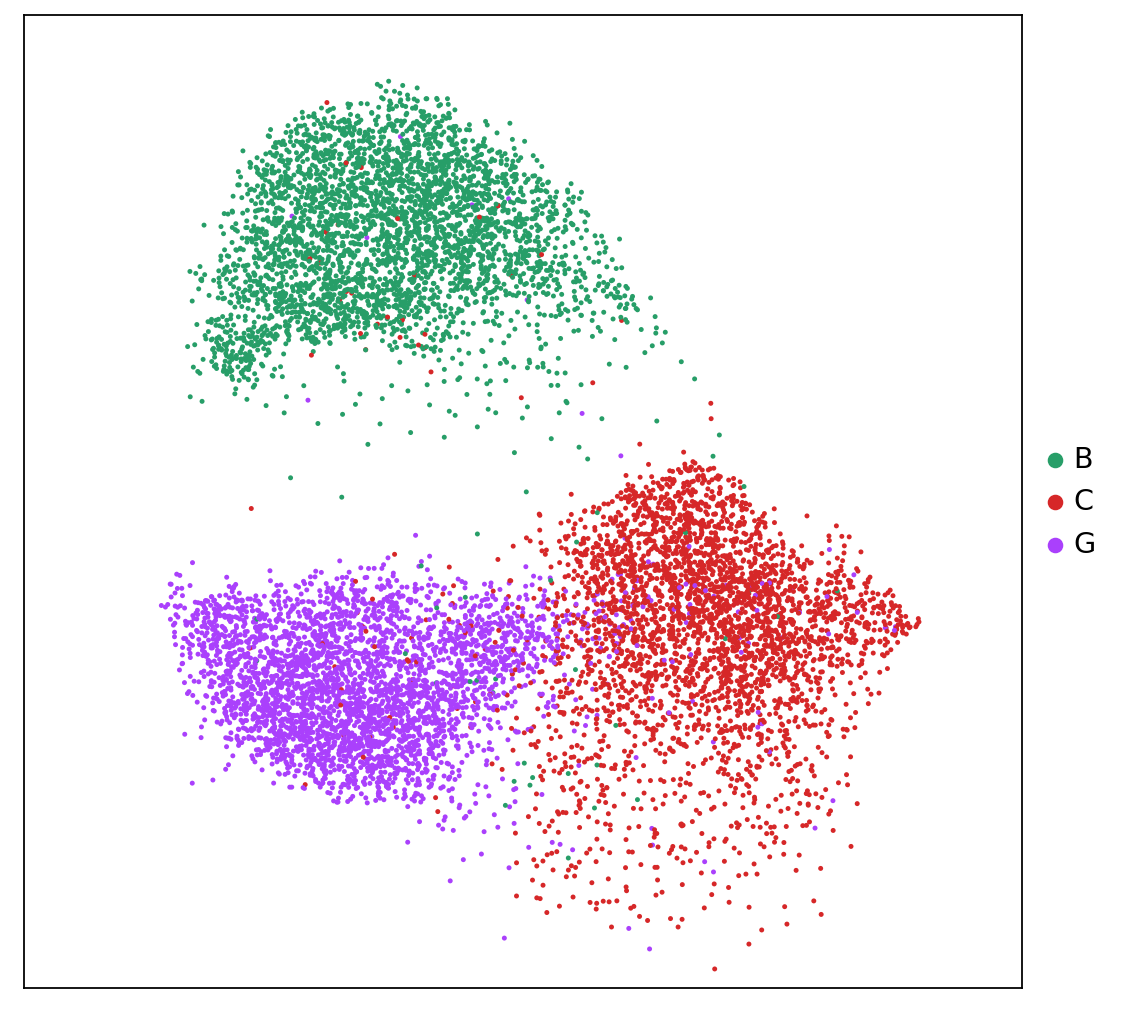

In [59]:
# targets = [target] if target in counts.var_names else gene
target = 'cond'

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax = sc.pl.umap(counts, color=target, ax=ax, show=False, 
                use_raw=False, return_fig=False, size=20, title='',
                sort_order=True
                )
# ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xlim(xlim)
ax.set_ylim(ylim);

0.05231191692447898 0.07340051442549825


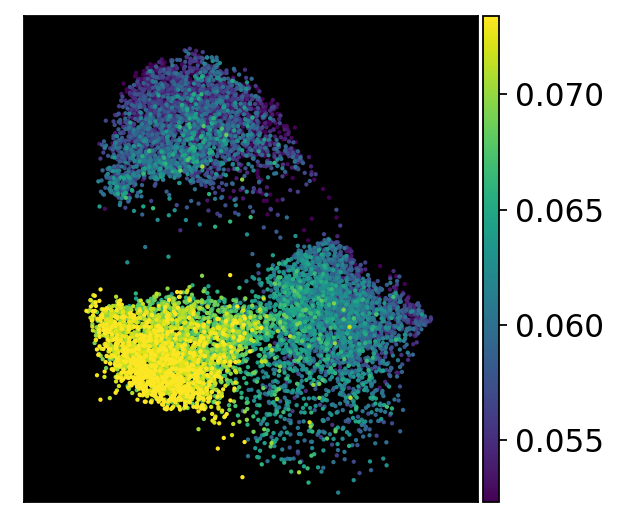

In [61]:
target = 'IRF1(+)'

print(vmin, vmax)
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_facecolor('black')
ax = sc.pl.umap(counts, color=target, ax=ax, show=False, 
                use_raw=False, return_fig=False, size=15, title='',
                vmin=vmin, vmax=vmax, 
                sort_order=True
                )
# fig.axes[-1].set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xlim(xlim)
ax.set_ylim(ylim);

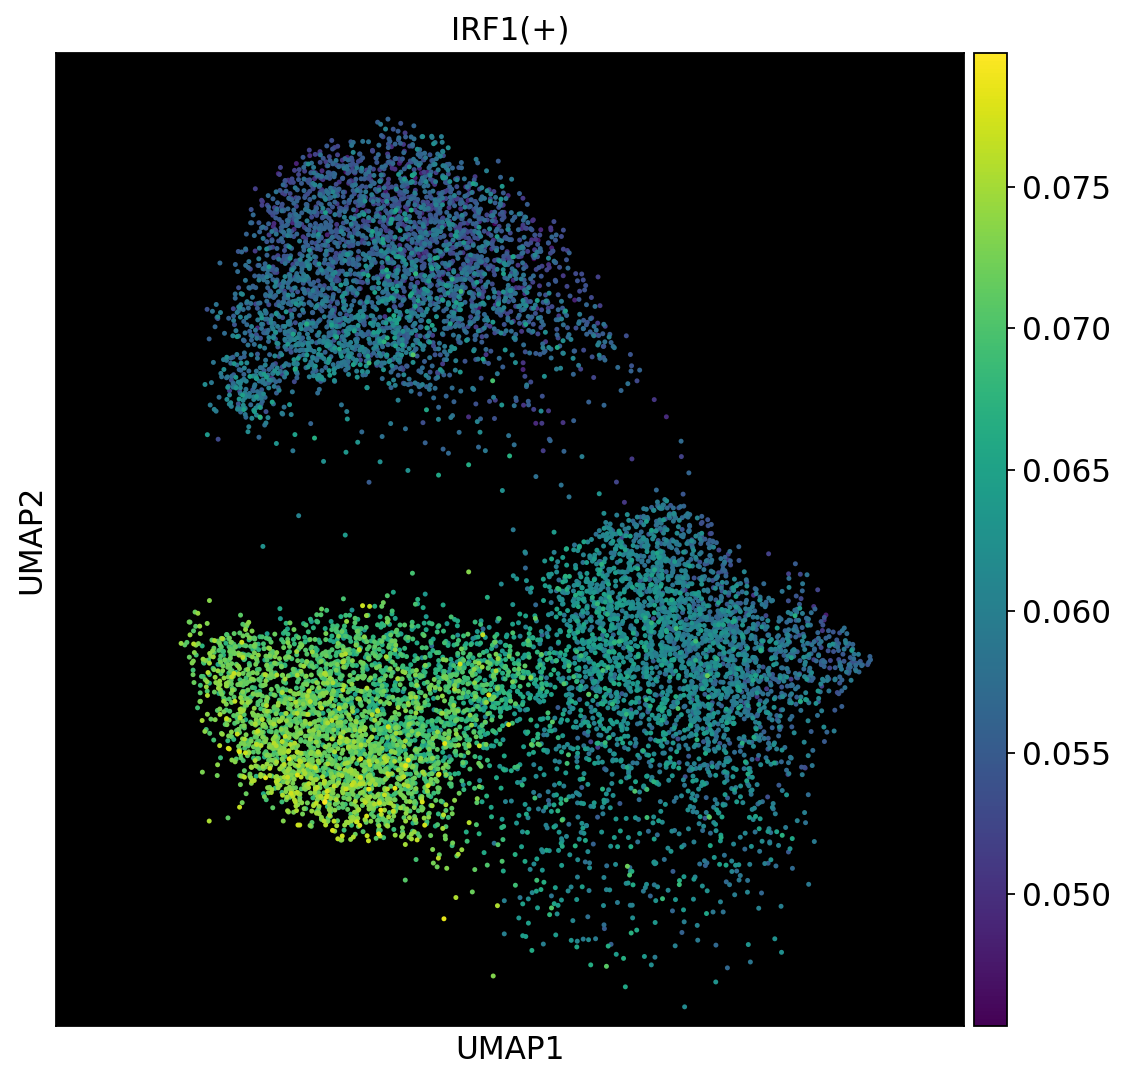

In [68]:
feature = 'IRF1(+)'
vmin, vmax = np.quantile(counts.obs_vector(target), q=[0.05, 0.95])
ax = nr.highlight_feature(counts, feature, use_raw=False, bg='black')
ax.set_xlim(xlim)
ax.set_ylim(ylim);